### Import dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import networkx
import scipy
from itertools import product
import pickle
import copy
from scipy.stats import sem
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable



In [2]:

EXIT = 'exit'

RED = 1
ROTATE180 = 'rotate180'
CUP = 1
RED_CUP = (RED, CUP)

In [3]:
filename = '../simple_one_object/movemdp_trajectories_feats_large_perm_biggergrid_1obj_w_policies_allphi_pi.pkl'
# filename = '../simple_one_object/movemdp_redblue_sameloc.pkl'


with open(filename, 'rb') as f:
    trajs = pickle.load(f)
    
num_trajs = len(trajs)
# num_trajs = 20
start_idx = 0
print("num_trajs", num_trajs)


num_trajs 80


# Create Hypotheses

In [4]:
all_reward_weight_possilbilities = [[-1,-1,-1,-1],
                                        [-1,-1,-1,1],
                                        [-1,-1,1,-1],
                                        [-1,1,-1,-1],
                                        [1,-1,-1,-1],
                                        [-1,-1,1,1],
                                        [-1,1,-1,1],
                                        [-1,1,1,-1],
                                        [1,-1,-1,1],
                                        [1,-1,1,-1],
                                        [1,1,-1,-1],
                                        [-1,1,1,1],
                                        [1,-1,1,1],
                                        [1,1,-1,1],
                                        [1,1,1,-1],
                                        [1,1,1,1]]
for i in range(len(all_reward_weight_possilbilities)):
    all_reward_weight_possilbilities[i][1] *= 2
    all_reward_weight_possilbilities[i][2] *= 2
    all_reward_weight_possilbilities[i][3] *= 1
    

# Mask options (Phi)

In [5]:
f_options = [[1,1,1,1], [1,1,1,0], [1,1,0,1], [1,0,1,1], [0,1,1,1]]
# f_options = [[1,1,1,1]]

In [6]:
# permutations_of_true_f = list(itertools.permutations(true_f_idx))
idx_to_perm = dict(enumerate(f_options))
perm_to_idx = {tuple(v):k for k,v in idx_to_perm.items()}

all_w = all_reward_weight_possilbilities
idx_to_w = dict(enumerate(all_w))
w_to_idx = {tuple(v):k for k,v in idx_to_w.items()}

indices_joint_hyps = list(range(start_idx, num_trajs))


In [7]:
idx_to_w

{0: [-1, -2, -2, -1],
 1: [-1, -2, -2, 1],
 2: [-1, -2, 2, -1],
 3: [-1, 2, -2, -1],
 4: [1, -2, -2, -1],
 5: [-1, -2, 2, 1],
 6: [-1, 2, -2, 1],
 7: [-1, 2, 2, -1],
 8: [1, -2, -2, 1],
 9: [1, -2, 2, -1],
 10: [1, 2, -2, -1],
 11: [-1, 2, 2, 1],
 12: [1, -2, 2, 1],
 13: [1, 2, -2, 1],
 14: [1, 2, 2, -1],
 15: [1, 2, 2, 1]}

# Access hypotheses from dataset

In [8]:
wf_tup_to_hyp_idx_deets = {}
for i in trajs:
    f = trajs[i]['f']
    f_idx = perm_to_idx[tuple(f)]
    w_idx = trajs[i]['w_idx']
    keyname = (w_idx, f_idx)
    wf_tup_to_hyp_idx_deets[keyname] = {}
    wf_tup_to_hyp_idx_deets[keyname]['index'] = i
    wf_tup_to_hyp_idx_deets[keyname]['prob'] = 1/len(trajs)
    wf_tup_to_hyp_idx_deets[keyname]['f'] = f
    wf_tup_to_hyp_idx_deets[keyname]['w'] = trajs[i]['w']
    
    final_state = trajs[i]['final_state'][0]
    final_loc = final_state['grid'][RED_CUP]
    final_or = final_state['orientation']
    if final_or != 0:
        print("final_or", final_or)
    
#     if final_or == 0:
#         final_or = -np.pi/2
#     if final_or == np.pi:
#         final_or = np.pi/2
    final_state['orientation'] = final_or
    wf_tup_to_hyp_idx_deets[keyname]['final_state_tuple'] =(final_loc, final_or)
    wf_tup_to_hyp_idx_deets[keyname]['final_state'] = final_state




final_or 3.141592653589793
final_or 3.141592653589793
final_or 3.141592653589793
final_or 3.141592653589793
final_or 3.141592653589793
final_or 3.141592653589793
final_or 3.141592653589793
final_or 3.141592653589793
final_or 3.141592653589793
final_or 3.141592653589793
final_or 3.141592653589793
final_or 3.141592653589793
final_or 3.141592653589793
final_or 3.141592653589793
final_or 3.141592653589793
final_or 3.141592653589793
final_or 3.141592653589793
final_or 3.141592653589793
final_or 3.141592653589793
final_or 3.141592653589793
final_or 3.141592653589793
final_or 3.141592653589793
final_or 3.141592653589793
final_or 3.141592653589793
final_or 3.141592653589793
final_or 3.141592653589793
final_or 3.141592653589793
final_or 3.141592653589793
final_or 3.141592653589793
final_or 3.141592653589793
final_or 3.141592653589793
final_or 3.141592653589793


# Set true reward w and phi

In [9]:
true_reward_weights = [-1, -2, 2, -1]  # orientation, red prox, blue prox, pos y

true_f_idx = [1, 1, 1, 1]



# Define featurize state function

In [10]:
def featurize_state(current_state, true_f_indices):

    current_loc = current_state['grid'][object_type_tuple]

    dist_to_red_centroid = np.linalg.norm(np.array(current_loc) - np.array(red_centroid))
    dist_to_blue_centroid = np.linalg.norm(np.array(current_loc) - np.array(blue_centroid))

    orientation = current_state['orientation']
#     if orientation == np.pi:
#         orientation = np.pi/2
#     else:
#         orientation = -np.pi/2
    pos_y = current_loc[1]
    state_feature = np.array([orientation, dist_to_red_centroid, dist_to_blue_centroid, pos_y])

    # elementwise multiply by true_f_idx
    state_feature = np.multiply(state_feature, true_f_indices)

    return state_feature

In [11]:
def state_to_tuple(current_state):
    # convert current_state to tuple
    current_state_tup = []
    for obj_type in current_state['grid']:
        loc = current_state['grid'][obj_type]
        current_state_tup.append((obj_type, loc))
    current_state_tup = list(sorted(current_state_tup, key=lambda x: x[1]))

    current_state_tup.append(current_state['exit'])
    current_state_tup.append(current_state['orientation'])

    return tuple(current_state_tup)

def tuple_to_state(current_state_tup):
    # convert current_state to tuple
    current_state_tup = list(current_state_tup)
    current_state = {'grid': {}, 'orientation': 0, 'exit': False}
    for i in range(len(current_state_tup)-2):
        (obj_type, loc) =  current_state_tup[i]
        current_state['grid'][obj_type] = loc


    current_state['exit'] = current_state_tup[-2]
    current_state['orientation'] = current_state_tup[-1]

    return current_state

# Define initial state

In [12]:
object_type_tuple = RED_CUP
initial_object_locs = {object_type_tuple:(0, 0)}
    
initial_state = {}
initial_state['grid'] = copy.deepcopy(initial_object_locs)
initial_state['exit'] = False
initial_state['orientation'] = 0
        

In [13]:
initial_state

{'grid': {(1, 1): (0, 0)}, 'exit': False, 'orientation': 0}

# Define action set

In [14]:
directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]

all_actions_list = []
all_actions_list.extend(directions)
all_actions_list.append(EXIT)
all_actions_list.append(ROTATE180)


In [15]:
all_actions_list

[(0, 1), (0, -1), (1, 0), (-1, 0), 'exit', 'rotate180']

# Render function

In [16]:
x_min = -3
x_max = 4
y_min = -3
y_max = 4

all_coordinate_locations = list(product(range(x_min,x_max),
                                             range(y_min, y_max)))
# print("all coordinate locations", self.all_coordinate_locations)
# pdb.set_trace()
# red_centroid = (1,1)
# blue_centroid = (1,1)
red_centroid = (2,0)
blue_centroid = (-2,0)


In [17]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def getImage(path, zoom=0.05):
    # pdb.set_trace()
#     zoom = 0.05
    return OffsetImage(plt.imread(path), zoom=zoom)

In [18]:
def plot_state(current_state, timestep):
    
    plot_init_state = copy.deepcopy(current_state)

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    (ax1) = ax

    if current_state['exit'] is True:
        ax1.axvline(x=0, color='red', linewidth=10, alpha=0.1)
        ax1.axhline(y=0, color='red', linewidth=10, alpha=0.1)
    else:
        ax1.axvline(x=0, color='black', linewidth=7, alpha=0.1)
        ax1.axhline(y=0, color='black', linewidth=7, alpha=0.1)

    type_to_color = {object_type_tuple: 'red'}
    type_to_loc_init = {}

    # current_push = plot_init_state['currently_pushing']
    ax1.scatter(red_centroid[0],red_centroid[1], color='red', s=800, alpha=0.1)
    ax1.scatter(blue_centroid[0], blue_centroid[1], color='blue', s=800, alpha=0.1)

    path = '../simple_one_object/redcup.jpeg'
    path180 = '../simple_one_object/redcup_180.jpeg'
    orientation = plot_init_state['orientation']
    for type_o in plot_init_state['grid']:
        loc = plot_init_state['grid'][type_o]
        color = type_to_color[type_o]
        type_to_loc_init[type_o] = loc

        ax1.scatter(loc[0], loc[1], color=color, s=500, alpha=0.99)
        if orientation == 0:
            ab = AnnotationBbox(getImage(path), (loc[0], loc[1]), frameon=False)
            ax.add_artist(ab)
        else:
            ab = AnnotationBbox(getImage(path180), (loc[0], loc[1]), frameon=False)
            ax.add_artist(ab)
        # ab = AnnotationBbox(getImage(path), (loc[0], loc[1]), frameon=False)
        # ax.add_artist(ab)

    #         plt.text(loc[0], loc[1], str(type), fontsize=12)
    offset = 0.1
    top_offset = -0.9
    ax1.set_xlim(x_min - offset, x_max + top_offset)
    ax1.set_ylim(y_min - offset, y_max + top_offset)

    ax1.set_xticks(np.arange(x_min - 1, x_max + 1, 1))
    ax1.set_yticks(np.arange(y_min - 1, y_max + 1, 1))
    ax1.grid()
    if current_state['exit'] is True:
        ax1.set_title(f"State at Time {timestep}: FINAL STATE")
    else:
        ax1.set_title(f"State at Time {timestep}")
#     plt.savefig(f"rollouts/state_{timestep}.png")

    plt.show()
#     plt.close()

In [19]:
def plot_correction(chosen_state, corrected_state, initial_state, timestep):
    color='red'
    plot_init_state = copy.deepcopy(initial_state)

    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    (ax0, ax1, ax2) = ax
    
    # PLOT INITIAL STATE
    ax0.axvline(x=0, color='black', linewidth=7, alpha=0.1)
    ax0.axhline(y=0, color='black', linewidth=7, alpha=0.1)

    type_to_color = {object_type_tuple: 'red'}
    type_to_loc_init = {}

    # current_push = plot_init_state['currently_pushing']
    ax0.scatter(red_centroid[0],red_centroid[1], color='red', s=1300, alpha=0.1)
    ax0.scatter(blue_centroid[0], blue_centroid[1], color='blue', s=1300, alpha=0.1)

    path = '../simple_one_object/redcup.jpeg'
    path180 = '../simple_one_object/redcup_180.jpeg'
    orientation = plot_init_state['orientation']
    for type_o in plot_init_state['grid']:
        loc = plot_init_state['grid'][type_o]
        color = type_to_color[type_o]
        type_to_loc_init[type_o] = loc

#         ax1.scatter(loc[0], loc[1], color=color, s=500, alpha=0.99)
        if orientation == 0:
            ab = AnnotationBbox(getImage(path, zoom=0.04), (loc[0], loc[1]), frameon=False)
            ax0.add_artist(ab)
            ab = AnnotationBbox(getImage(path, zoom=0.04), (loc[0], loc[1]), frameon=False)
            ax1.add_artist(ab)
            
        else:
            ab = AnnotationBbox(getImage(path180, zoom=0.04), (loc[0], loc[1]), frameon=False)
            ax0.add_artist(ab)
            ab = AnnotationBbox(getImage(path180, zoom=0.04), (loc[0], loc[1]), frameon=False)
            ax1.add_artist(ab)
        # ab = AnnotationBbox(getImage(path), (loc[0], loc[1]), frameon=False)
        # ax.add_artist(ab)
    start_loc = (loc[0], loc[1])
    #         plt.text(loc[0], loc[1], str(type), fontsize=12)
    offset = 0.1
    top_offset = -0.9
    ax0.set_xlim(x_min - offset, x_max + top_offset)
    ax0.set_ylim(y_min - offset, y_max + top_offset)

    ax0.set_xticks(np.arange(x_min - 1, x_max + 1, 1))
    ax0.set_yticks(np.arange(y_min - 1, y_max + 1, 1))
    ax0.grid()
#     if current_state['exit'] is True:
#         ax1.set_title(f"Robot moves: State at Time {timestep}: FINAL STATE")
#     else:
    ax0.set_title(f"Initial State at Time {timestep}")
    
    
    

#     if current_state['exit'] is True:
#         ax1.axvline(x=0, color='red', linewidth=10, alpha=0.1)
#         ax1.axhline(y=0, color='red', linewidth=10, alpha=0.1)
#     else:
    plot_init_state = copy.deepcopy(chosen_state)

    ax1.axvline(x=0, color='black', linewidth=7, alpha=0.1)
    ax1.axhline(y=0, color='black', linewidth=7, alpha=0.1)

    type_to_color = {object_type_tuple: 'red'}
    type_to_loc_init = {}

    # current_push = plot_init_state['currently_pushing']
    ax1.scatter(red_centroid[0],red_centroid[1], color='red', s=1300, alpha=0.1)
    ax1.scatter(blue_centroid[0], blue_centroid[1], color='blue', s=1300, alpha=0.1)

    path = '../simple_one_object/redcup.jpeg'
    path180 = '../simple_one_object/redcup_180.jpeg'
    orientation = plot_init_state['orientation']
    for type_o in plot_init_state['grid']:
        loc = plot_init_state['grid'][type_o]
        color = type_to_color[type_o]
        type_to_loc_init[type_o] = loc

#         ax1.scatter(loc[0], loc[1], color=color, s=500, alpha=0.99)
        if orientation == 0:
            ab = AnnotationBbox(getImage(path), (loc[0], loc[1]), frameon=False)
            ax1.add_artist(ab)
            ab = AnnotationBbox(getImage(path), (loc[0], loc[1]), frameon=False)
            ax2.add_artist(ab)
            
        else:
            ab = AnnotationBbox(getImage(path180), (loc[0], loc[1]), frameon=False)
            ax1.add_artist(ab)
            ab = AnnotationBbox(getImage(path180), (loc[0], loc[1]), frameon=False)
            ax2.add_artist(ab)
        # ab = AnnotationBbox(getImage(path), (loc[0], loc[1]), frameon=False)
        # ax.add_artist(ab)

    #         plt.text(loc[0], loc[1], str(type), fontsize=12)
    
    x1, y1 = np.array([start_loc[0], start_loc[1]])
    x2, y2 = np.array([loc[0], loc[1]])

    if (x1,y1) != (x2, y2):

        ax1.quiver(x1, y1, (x2-x1), (y2-y1), angles='xy', 
                       scale_units='xy', scale=1, hatch='ooo',
                       facecolor=color, alpha=0.99, label='robot moves',
                       linewidth=1,width=0.01, headwidth=10, headlength=10)
    offset = 0.1
    top_offset = -0.9
    ax1.set_xlim(x_min - offset, x_max + top_offset)
    ax1.set_ylim(y_min - offset, y_max + top_offset)

    ax1.set_xticks(np.arange(x_min - 1, x_max + 1, 1))
    ax1.set_yticks(np.arange(y_min - 1, y_max + 1, 1))
    ax1.grid()
#     if current_state['exit'] is True:
#         ax1.set_title(f"Robot moves: State at Time {timestep}: FINAL STATE")
#     else:
    ax1.set_title(f"Robot moves: State at Time {timestep}")
#     plt.savefig(f"rollouts/state_{timestep}.png")
    initial_loc = (loc[0], loc[1])


    # robot placed object
    #         fig, ax = plt.subplots()
    plot_init_state = copy.deepcopy(corrected_state)

#     if current_state['exit'] is True:
#         ax2.axvline(x=0, color='red', linewidth=10, alpha=0.1)
#         ax2.axhline(y=0, color='red', linewidth=10, alpha=0.1)
#     else:
    ax2.axvline(x=0, color='black', linewidth=7, alpha=0.1)
    ax2.axhline(y=0, color='black', linewidth=7, alpha=0.1)

    type_to_color = {object_type_tuple: 'red'}
    type_to_loc_init = {}

    # current_push = plot_init_state['currently_pushing']
    ax2.scatter(red_centroid[0],red_centroid[1], color='red', s=1300, alpha=0.1)
    ax2.scatter(blue_centroid[0], blue_centroid[1], color='blue', s=1300, alpha=0.1)

    path = '../simple_one_object/redcup.jpeg'
    path180 = '../simple_one_object/redcup_180.jpeg'
    orientation = plot_init_state['orientation']
    for type_o in plot_init_state['grid']:
        loc = plot_init_state['grid'][type_o]
        color = type_to_color[type_o]
        type_to_loc_init[type_o] = loc

#         ax2.scatter(initial_loc[0], initial_loc[1], color=color, s=700, alpha=0.2)
#         ax2.scatter(loc[0], loc[1], color=color, s=500, alpha=0.99)
#         if orientation == 0:
#             ab = AnnotationBbox(getImage(path), (initial_loc[0], initial_loc[1]), frameon=False)
#             ax2.add_artist(ab)
#         else:
#             ab = AnnotationBbox(getImage(path180), (loc[0], loc[1]), frameon=False)
#             ax2.add_artist(ab)
            
        if orientation == 0:
            ab = AnnotationBbox(getImage(path, zoom=0.07), (loc[0], loc[1]), frameon=False)
            ax2.add_artist(ab)
        else:
            ab = AnnotationBbox(getImage(path180, zoom=0.07), (loc[0], loc[1]), frameon=False)
            ax2.add_artist(ab)


    #         plt.text(loc[0], loc[1], str(type), fontsize=12)
    x1, y1 = np.array([initial_loc[0], initial_loc[1]])
    x2, y2 = np.array([loc[0], loc[1]])

    if (x1,y1) != (x2, y2):

        ax2.quiver(x1, y1, (x2-x1), (y2-y1), angles='xy', 
                       scale_units='xy', scale=1, hatch='ooo',
                       facecolor=color, alpha=0.99, label='human corrects',
                       linewidth=1,width=0.01, headwidth=10, headlength=10)
        
    offset = 0.1
    top_offset = -0.9
    ax2.set_xlim(x_min - offset, x_max + top_offset)
    ax2.set_ylim(y_min - offset, y_max + top_offset)

    ax2.set_xticks(np.arange(x_min - 1, x_max + 1, 1))
    ax2.set_yticks(np.arange(y_min - 1, y_max + 1, 1))
    ax2.grid()
#     if current_state['exit'] is True:
#         ax1.set_title(f"Robot moves: State at Time {timestep}: FINAL STATE")
#     else:
    ax2.set_title(f"Human Corrects: State at Time {timestep}")
    
    
    ax2.legend()
    plt.show()
    plt.close()



# Define function to plot heatmap

In [20]:
def plot_heatmap(wf_tuple_to_beliefs, perm_to_idx, w_to_idx):
    # make heatmap

    # inputs
    # wf_tup_to_hyp_idx_deets
    # perm_to_idx, w_to_idx, idx_to_perm, idx_to_w

    # print("perm_to_idx", perm_to_idx)
    # print()
    # print("w_to_idx", w_to_idx)

    num_perm = len(perm_to_idx)
    num_w = len(w_to_idx)

    heat_grid = np.zeros((num_perm, num_w))



    for keyname in wf_tuple_to_beliefs:
    #         counter_index = wf_tup_to_hyp_idx_deets[keyname]['index']
        heat_grid[(keyname[1], keyname[0])] = wf_tuple_to_beliefs[keyname]

#     print("heat_grid", heat_grid)
    fig, ax = plt.subplots(figsize=(10,5))
    im = ax.imshow(heat_grid, cmap='Blues', interpolation='nearest')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)

    fig.colorbar(im, cax=cax, orientation='vertical')

    plt.show()
    plt.close()

#     print(np.amax(heat_grid))






In [21]:
def plot_rewardmap(wf_tuple_to_beliefs, perm_to_idx, w_to_idx):
    # make heatmap

    # inputs
    # wf_tup_to_hyp_idx_deets
    # perm_to_idx, w_to_idx, idx_to_perm, idx_to_w

    # print("perm_to_idx", perm_to_idx)
    # print()
    # print("w_to_idx", w_to_idx)

    num_perm = len(perm_to_idx)
    num_w = len(w_to_idx)

    heat_grid = np.zeros((num_perm, num_w))



    for keyname in wf_tuple_to_beliefs:
    #         counter_index = wf_tup_to_hyp_idx_deets[keyname]['index']
        heat_grid[(keyname[1], keyname[0])] = wf_tuple_to_beliefs[keyname]

#     print("heat_grid", heat_grid)
    fig, ax = plt.subplots(figsize=(10,5))
    im = ax.imshow(heat_grid, cmap='Reds', interpolation='nearest')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)

    fig.colorbar(im, cax=cax, orientation='vertical')

    plt.show()
    plt.close()

#     print(np.amax(heat_grid))






# Test Plotting Corrections

In [22]:
object_type_tuple

(1, 1)

In [23]:
wf_tup_to_hyp_idx_deets[(0,0)]

{'index': 0,
 'prob': 0.0125,
 'f': [1, 1, 1, 1],
 'w': [-1, -2, -2, -1],
 'final_state_tuple': ((0, -1), 0),
 'final_state': {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}}

In [24]:
tup_test = (0,0)





In [25]:
initial_state['orientation'] = 0

max_keytuple (8, 4)
map_robot_state {'grid': {(1, 1): (0, 1)}, 'exit': False, 'orientation': 0}
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}


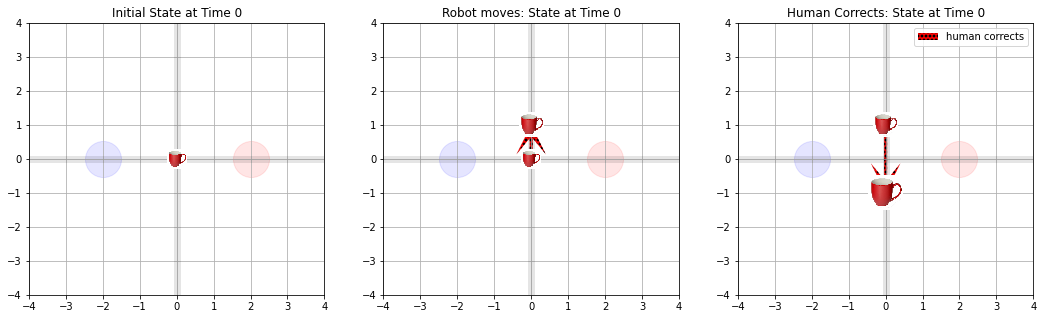

keytuple == (0,0)
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}
corrected_state_feat_wrt_candidate_phi [ 0.          2.23606798  2.23606798 -1.        ]
corrected_reward_wrt_candidate_wphi =  -8.94427190999916
subopt_reward_wrt_candidate_wphi =  -10.94427190999916
rew:  -10.94427190999916
upside down rew:  -15.085864563588952


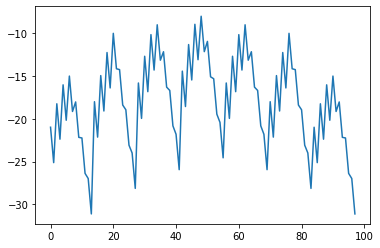

prob_data_given_w_phi 0.13638686320887244

keytuple == (0,4)
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}
corrected_state_feat_wrt_candidate_phi [ 0.          2.23606798  2.23606798 -1.        ]
corrected_reward_wrt_candidate_wphi =  -8.94427190999916
subopt_reward_wrt_candidate_wphi =  -10.94427190999916
rew:  -10.94427190999916
upside down rew:  -11.94427190999916


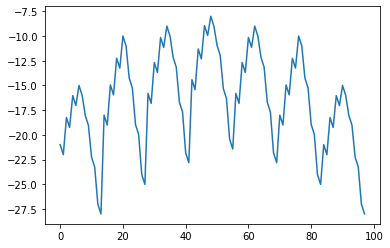

prob_data_given_w_phi 0.10129187620408374

keytuple == (4,0)
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 3.141592653589793}
corrected_state_feat_wrt_candidate_phi [ 0.          2.23606798  2.23606798 -1.        ]
corrected_reward_wrt_candidate_wphi =  -8.94427190999916
subopt_reward_wrt_candidate_wphi =  -10.94427190999916
rew:  -10.94427190999916
upside down rew:  -8.802679256409366


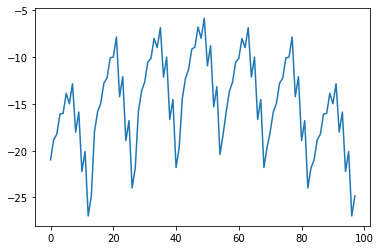

prob_data_given_w_phi 0.014564836792917894



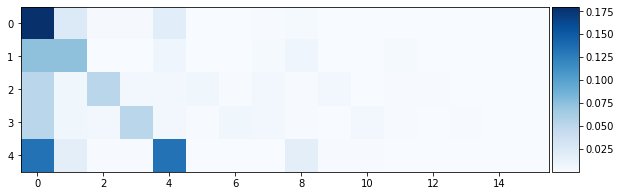

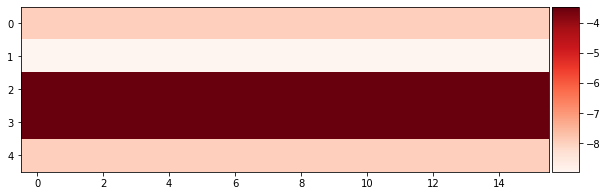

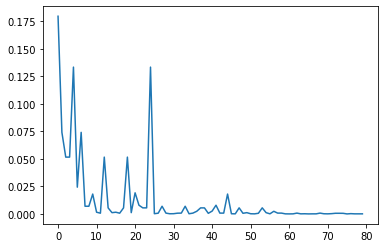

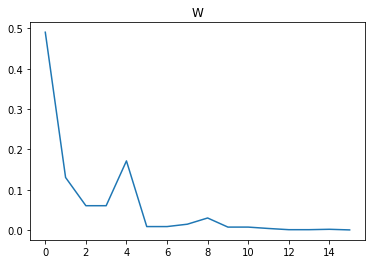

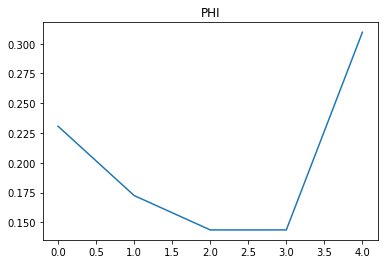

No handles with labels found to put in legend.


max_keytuple (0, 0)
map_robot_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}


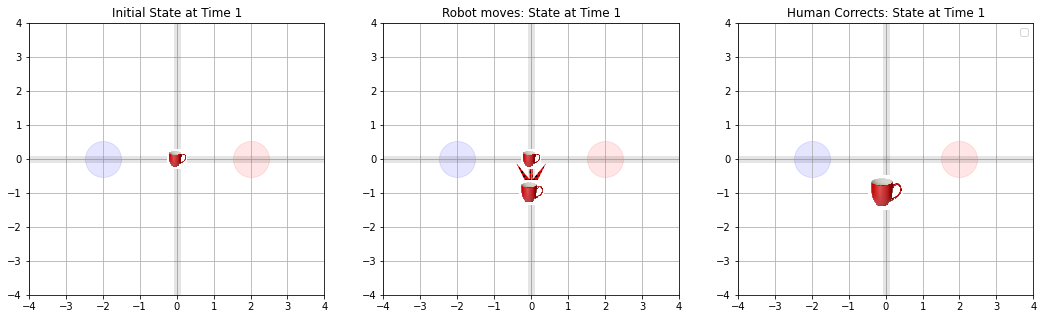

keytuple == (0,0)
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}
corrected_state_feat_wrt_candidate_phi [ 0.          2.23606798  2.23606798 -1.        ]
corrected_reward_wrt_candidate_wphi =  -8.94427190999916
subopt_reward_wrt_candidate_wphi =  -8.94427190999916
rew:  -8.94427190999916
upside down rew:  -13.085864563588952


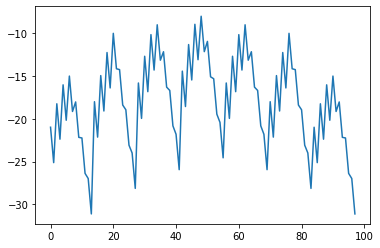

prob_data_given_w_phi 0.13638686320887244

keytuple == (0,4)
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}
corrected_state_feat_wrt_candidate_phi [ 0.          2.23606798  2.23606798 -1.        ]
corrected_reward_wrt_candidate_wphi =  -8.94427190999916
subopt_reward_wrt_candidate_wphi =  -8.94427190999916
rew:  -8.94427190999916
upside down rew:  -9.94427190999916


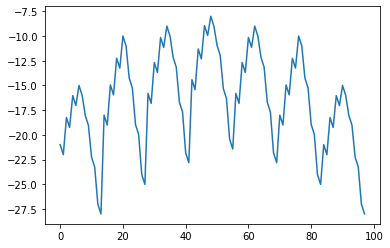

prob_data_given_w_phi 0.10129187620408374

keytuple == (4,0)
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 3.141592653589793}
corrected_state_feat_wrt_candidate_phi [ 0.          2.23606798  2.23606798 -1.        ]
corrected_reward_wrt_candidate_wphi =  -8.94427190999916
subopt_reward_wrt_candidate_wphi =  -8.94427190999916
rew:  -8.94427190999916
upside down rew:  -6.802679256409366


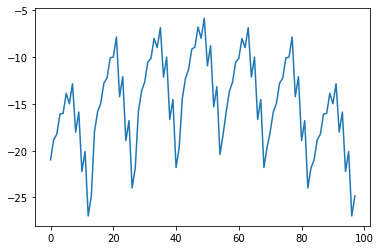

prob_data_given_w_phi 0.014564836792917894



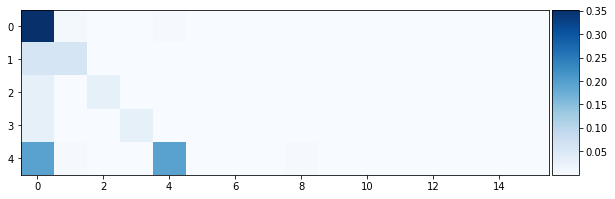

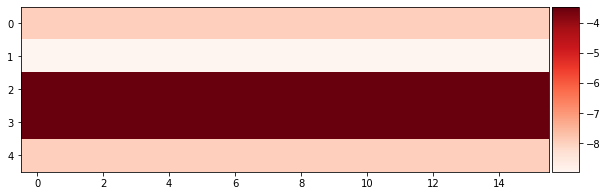

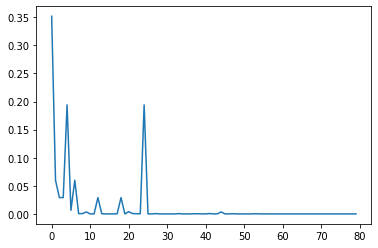

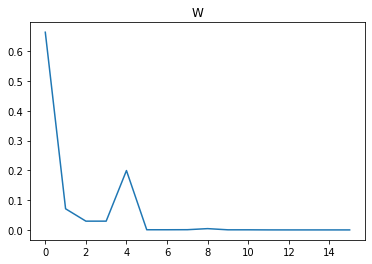

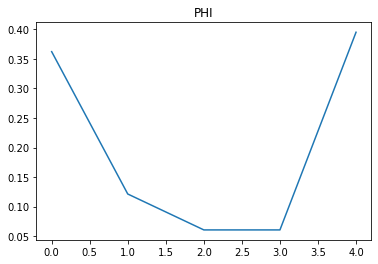

No handles with labels found to put in legend.


max_keytuple (0, 0)
map_robot_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}


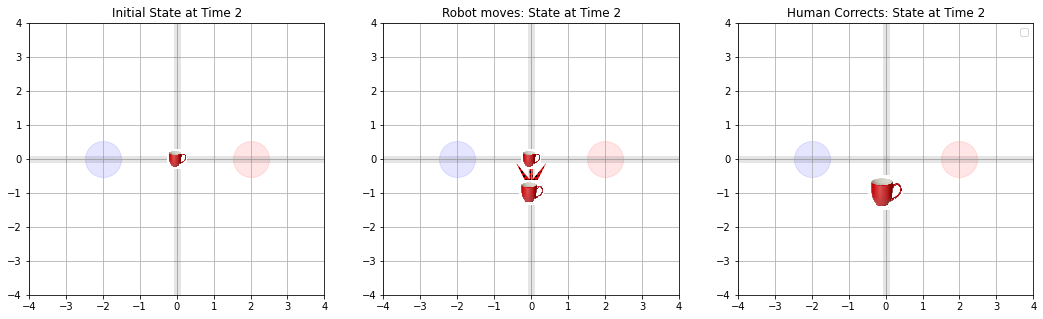

keytuple == (0,0)
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}
corrected_state_feat_wrt_candidate_phi [ 0.          2.23606798  2.23606798 -1.        ]
corrected_reward_wrt_candidate_wphi =  -8.94427190999916
subopt_reward_wrt_candidate_wphi =  -8.94427190999916
rew:  -8.94427190999916
upside down rew:  -13.085864563588952


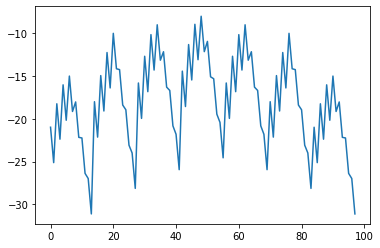

prob_data_given_w_phi 0.13638686320887244

keytuple == (0,4)
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}
corrected_state_feat_wrt_candidate_phi [ 0.          2.23606798  2.23606798 -1.        ]
corrected_reward_wrt_candidate_wphi =  -8.94427190999916
subopt_reward_wrt_candidate_wphi =  -8.94427190999916
rew:  -8.94427190999916
upside down rew:  -9.94427190999916


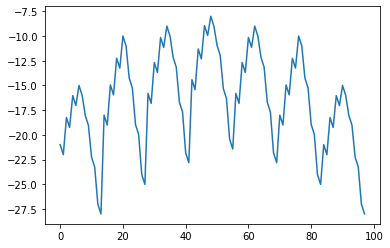

prob_data_given_w_phi 0.10129187620408374

keytuple == (4,0)
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 3.141592653589793}
corrected_state_feat_wrt_candidate_phi [ 0.          2.23606798  2.23606798 -1.        ]
corrected_reward_wrt_candidate_wphi =  -8.94427190999916
subopt_reward_wrt_candidate_wphi =  -8.94427190999916
rew:  -8.94427190999916
upside down rew:  -6.802679256409366


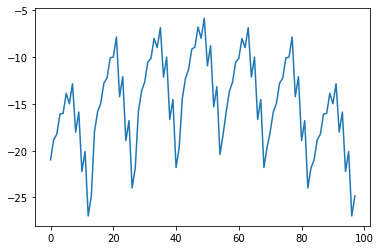

prob_data_given_w_phi 0.014564836792917894



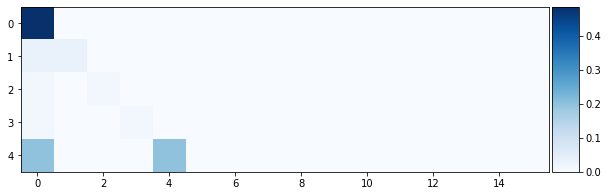

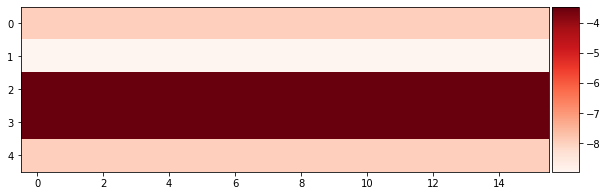

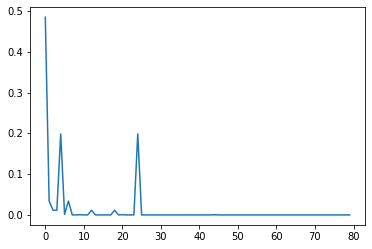

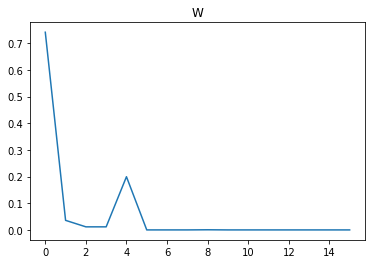

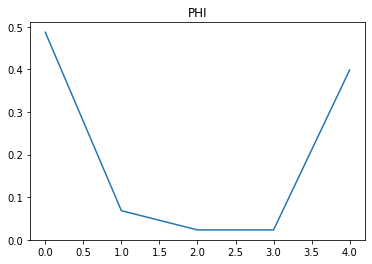

No handles with labels found to put in legend.


max_keytuple (0, 0)
map_robot_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}


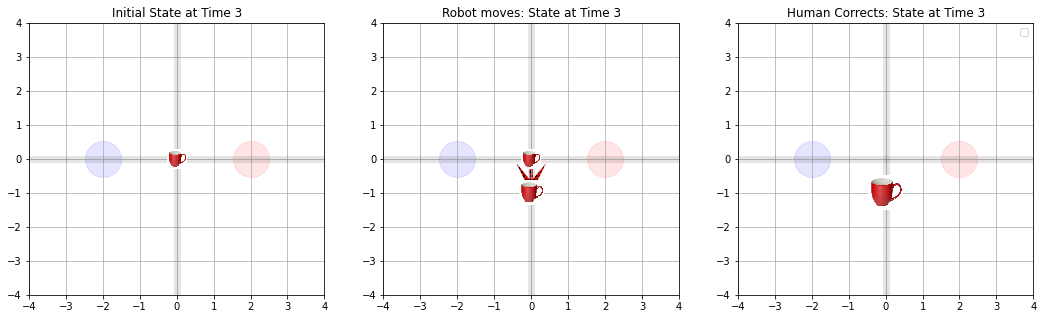

keytuple == (0,0)
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}
corrected_state_feat_wrt_candidate_phi [ 0.          2.23606798  2.23606798 -1.        ]
corrected_reward_wrt_candidate_wphi =  -8.94427190999916
subopt_reward_wrt_candidate_wphi =  -8.94427190999916
rew:  -8.94427190999916
upside down rew:  -13.085864563588952


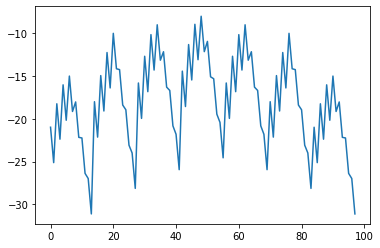

prob_data_given_w_phi 0.13638686320887244

keytuple == (0,4)
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}
corrected_state_feat_wrt_candidate_phi [ 0.          2.23606798  2.23606798 -1.        ]
corrected_reward_wrt_candidate_wphi =  -8.94427190999916
subopt_reward_wrt_candidate_wphi =  -8.94427190999916
rew:  -8.94427190999916
upside down rew:  -9.94427190999916


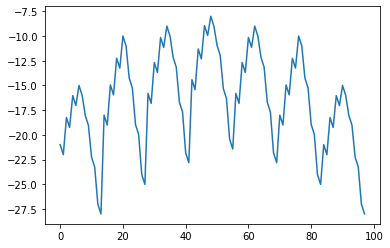

prob_data_given_w_phi 0.10129187620408374

keytuple == (4,0)
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 3.141592653589793}
corrected_state_feat_wrt_candidate_phi [ 0.          2.23606798  2.23606798 -1.        ]
corrected_reward_wrt_candidate_wphi =  -8.94427190999916
subopt_reward_wrt_candidate_wphi =  -8.94427190999916
rew:  -8.94427190999916
upside down rew:  -6.802679256409366


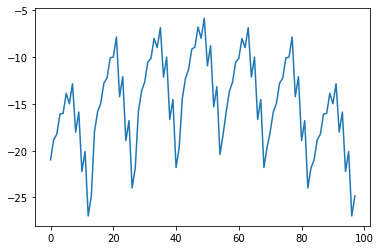

prob_data_given_w_phi 0.014564836792917894



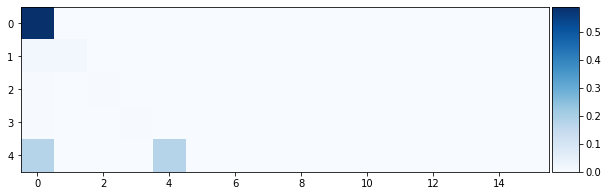

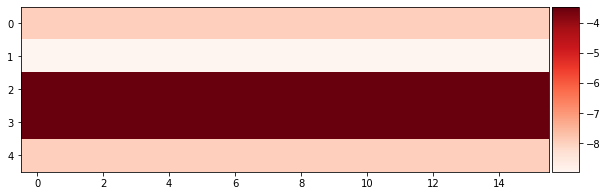

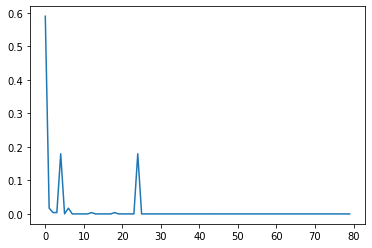

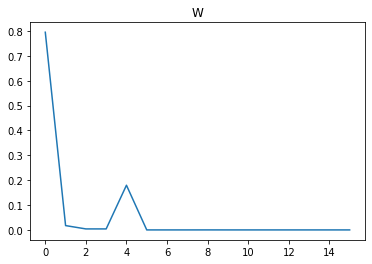

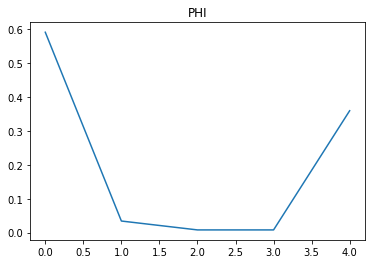

No handles with labels found to put in legend.


max_keytuple (0, 0)
map_robot_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}


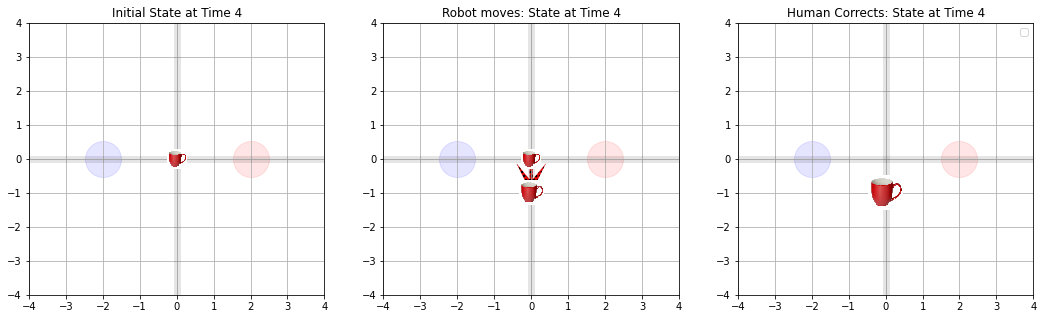

keytuple == (0,0)
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}
corrected_state_feat_wrt_candidate_phi [ 0.          2.23606798  2.23606798 -1.        ]
corrected_reward_wrt_candidate_wphi =  -8.94427190999916
subopt_reward_wrt_candidate_wphi =  -8.94427190999916
rew:  -8.94427190999916
upside down rew:  -13.085864563588952


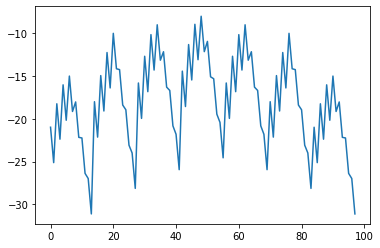

prob_data_given_w_phi 0.13638686320887244

keytuple == (0,4)
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}
corrected_state_feat_wrt_candidate_phi [ 0.          2.23606798  2.23606798 -1.        ]
corrected_reward_wrt_candidate_wphi =  -8.94427190999916
subopt_reward_wrt_candidate_wphi =  -8.94427190999916
rew:  -8.94427190999916
upside down rew:  -9.94427190999916


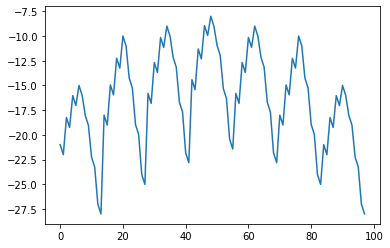

prob_data_given_w_phi 0.10129187620408374

keytuple == (4,0)
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 3.141592653589793}
corrected_state_feat_wrt_candidate_phi [ 0.          2.23606798  2.23606798 -1.        ]
corrected_reward_wrt_candidate_wphi =  -8.94427190999916
subopt_reward_wrt_candidate_wphi =  -8.94427190999916
rew:  -8.94427190999916
upside down rew:  -6.802679256409366


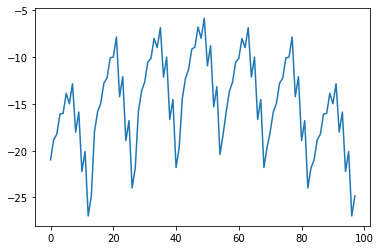

prob_data_given_w_phi 0.014564836792917894



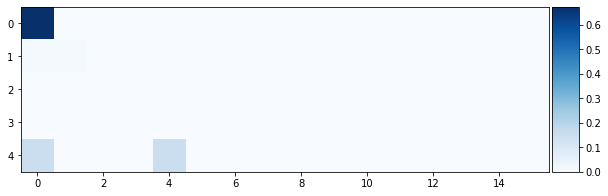

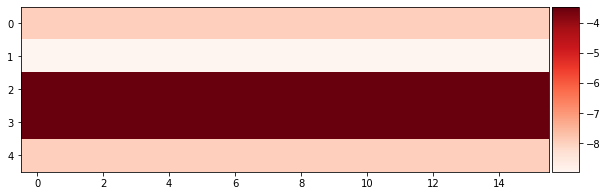

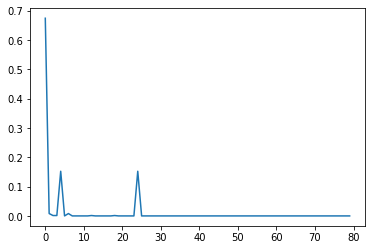

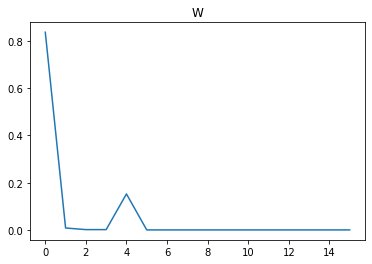

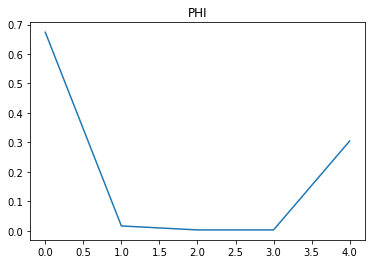

No handles with labels found to put in legend.


max_keytuple (0, 0)
map_robot_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}


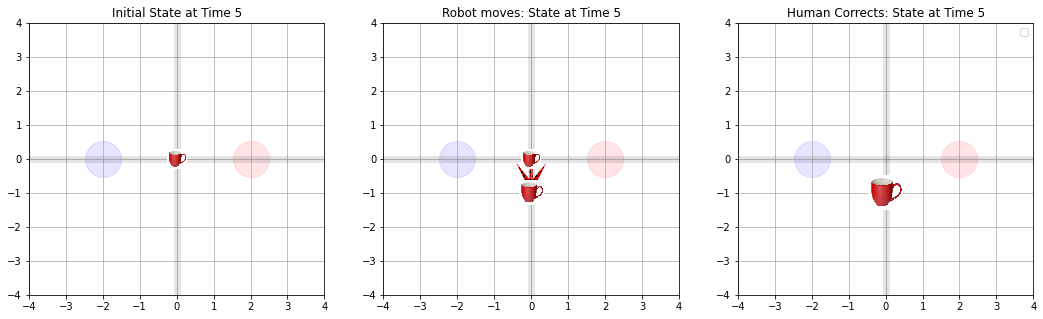

keytuple == (0,0)
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}
corrected_state_feat_wrt_candidate_phi [ 0.          2.23606798  2.23606798 -1.        ]
corrected_reward_wrt_candidate_wphi =  -8.94427190999916
subopt_reward_wrt_candidate_wphi =  -8.94427190999916
rew:  -8.94427190999916
upside down rew:  -13.085864563588952


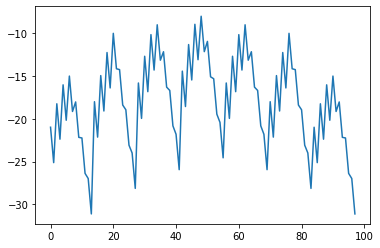

prob_data_given_w_phi 0.13638686320887244

keytuple == (0,4)
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}
corrected_state_feat_wrt_candidate_phi [ 0.          2.23606798  2.23606798 -1.        ]
corrected_reward_wrt_candidate_wphi =  -8.94427190999916
subopt_reward_wrt_candidate_wphi =  -8.94427190999916
rew:  -8.94427190999916
upside down rew:  -9.94427190999916


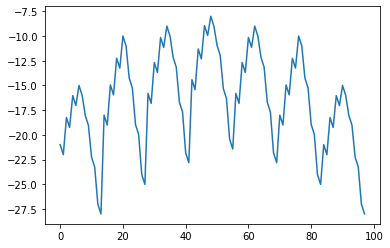

prob_data_given_w_phi 0.10129187620408374

keytuple == (4,0)
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 3.141592653589793}
corrected_state_feat_wrt_candidate_phi [ 0.          2.23606798  2.23606798 -1.        ]
corrected_reward_wrt_candidate_wphi =  -8.94427190999916
subopt_reward_wrt_candidate_wphi =  -8.94427190999916
rew:  -8.94427190999916
upside down rew:  -6.802679256409366


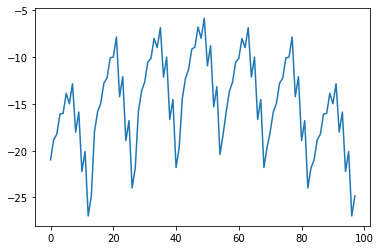

prob_data_given_w_phi 0.014564836792917894



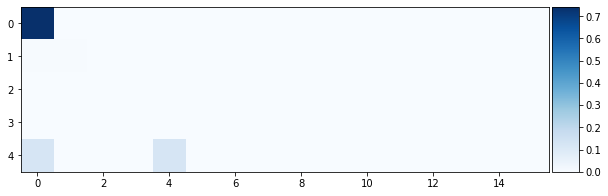

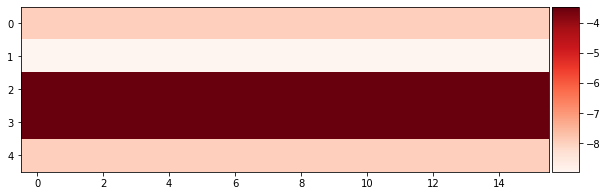

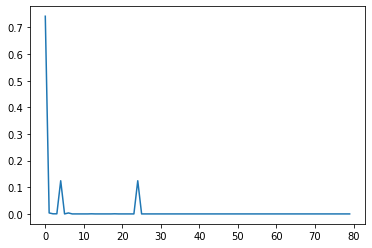

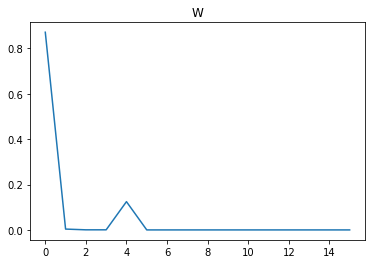

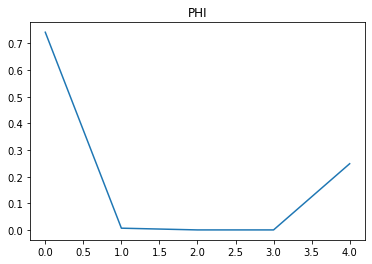

No handles with labels found to put in legend.


max_keytuple (0, 0)
map_robot_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}


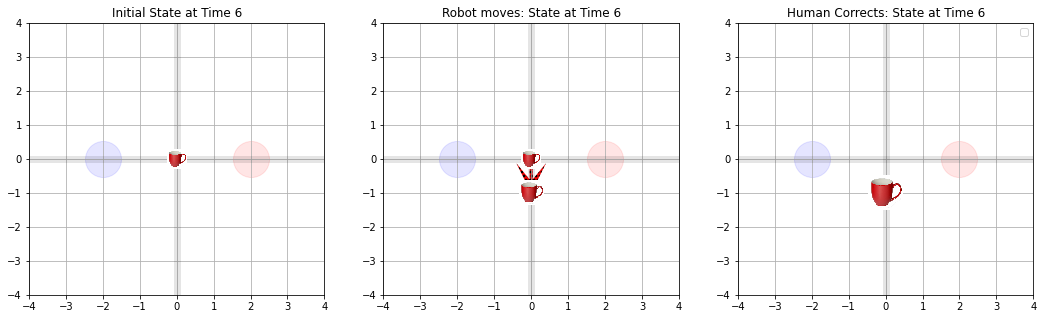

keytuple == (0,0)
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}
corrected_state_feat_wrt_candidate_phi [ 0.          2.23606798  2.23606798 -1.        ]
corrected_reward_wrt_candidate_wphi =  -8.94427190999916
subopt_reward_wrt_candidate_wphi =  -8.94427190999916
rew:  -8.94427190999916
upside down rew:  -13.085864563588952


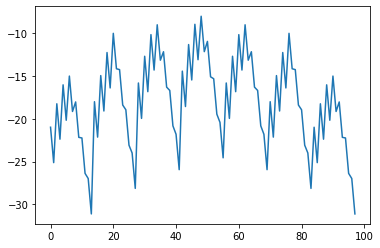

prob_data_given_w_phi 0.13638686320887244

keytuple == (0,4)
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}
corrected_state_feat_wrt_candidate_phi [ 0.          2.23606798  2.23606798 -1.        ]
corrected_reward_wrt_candidate_wphi =  -8.94427190999916
subopt_reward_wrt_candidate_wphi =  -8.94427190999916
rew:  -8.94427190999916
upside down rew:  -9.94427190999916


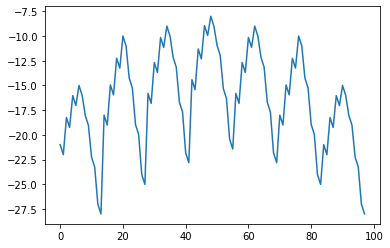

prob_data_given_w_phi 0.10129187620408374

keytuple == (4,0)
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 3.141592653589793}
corrected_state_feat_wrt_candidate_phi [ 0.          2.23606798  2.23606798 -1.        ]
corrected_reward_wrt_candidate_wphi =  -8.94427190999916
subopt_reward_wrt_candidate_wphi =  -8.94427190999916
rew:  -8.94427190999916
upside down rew:  -6.802679256409366


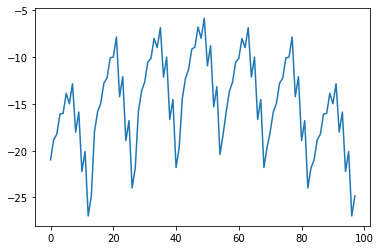

prob_data_given_w_phi 0.014564836792917894



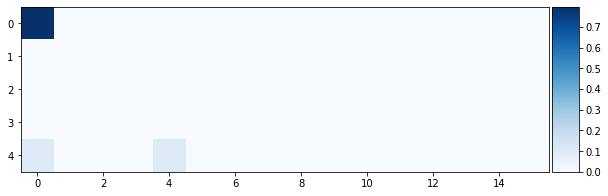

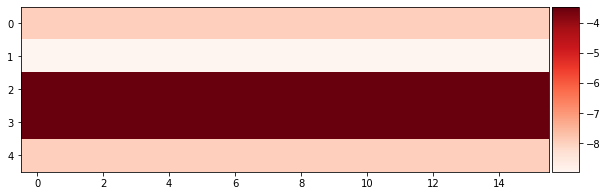

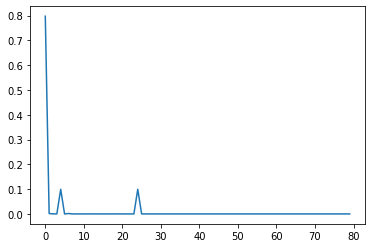

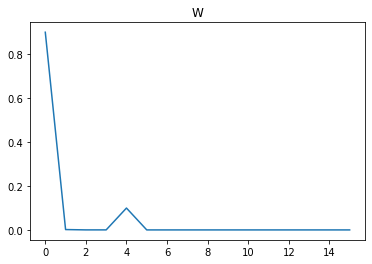

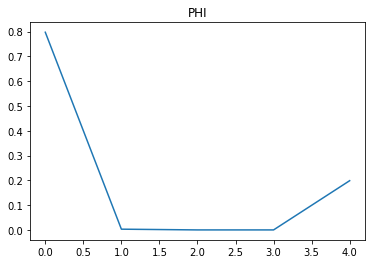

No handles with labels found to put in legend.


max_keytuple (0, 0)
map_robot_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}


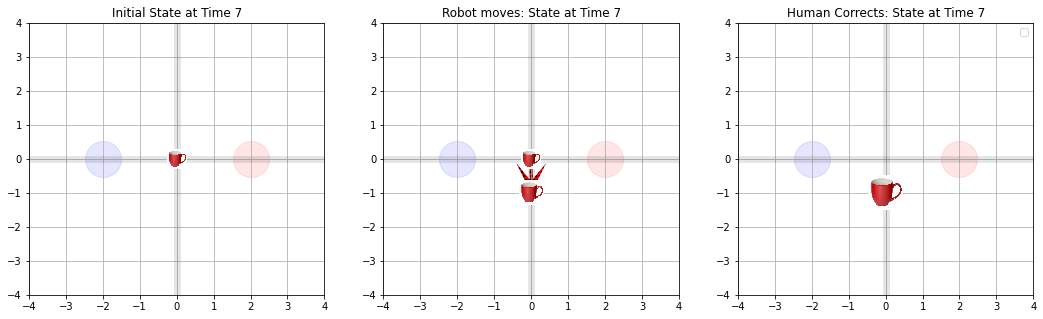

keytuple == (0,0)
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}
corrected_state_feat_wrt_candidate_phi [ 0.          2.23606798  2.23606798 -1.        ]
corrected_reward_wrt_candidate_wphi =  -8.94427190999916
subopt_reward_wrt_candidate_wphi =  -8.94427190999916
rew:  -8.94427190999916
upside down rew:  -13.085864563588952


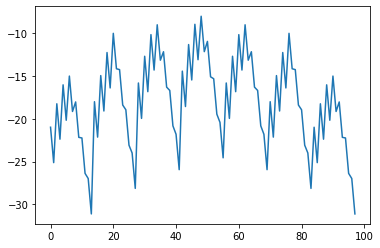

prob_data_given_w_phi 0.13638686320887244

keytuple == (0,4)
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}
corrected_state_feat_wrt_candidate_phi [ 0.          2.23606798  2.23606798 -1.        ]
corrected_reward_wrt_candidate_wphi =  -8.94427190999916
subopt_reward_wrt_candidate_wphi =  -8.94427190999916
rew:  -8.94427190999916
upside down rew:  -9.94427190999916


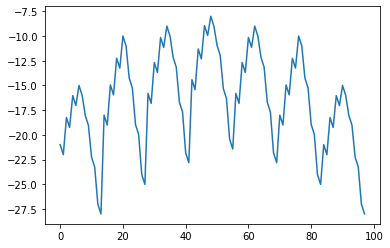

prob_data_given_w_phi 0.10129187620408374

keytuple == (4,0)
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 3.141592653589793}
corrected_state_feat_wrt_candidate_phi [ 0.          2.23606798  2.23606798 -1.        ]
corrected_reward_wrt_candidate_wphi =  -8.94427190999916
subopt_reward_wrt_candidate_wphi =  -8.94427190999916
rew:  -8.94427190999916
upside down rew:  -6.802679256409366


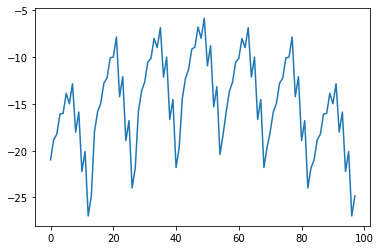

prob_data_given_w_phi 0.014564836792917894



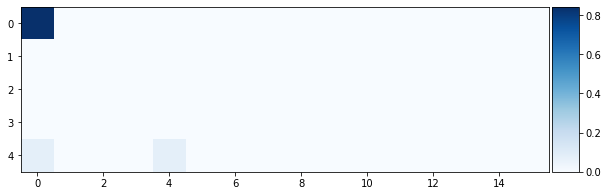

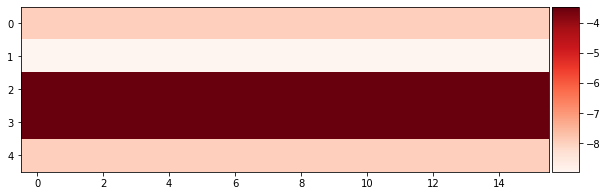

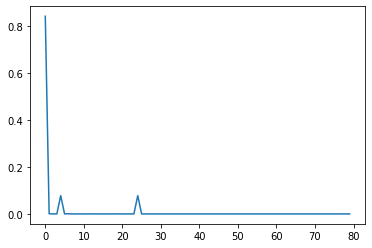

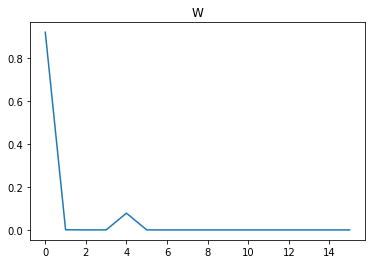

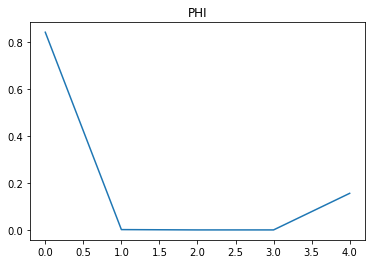

No handles with labels found to put in legend.


max_keytuple (0, 0)
map_robot_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}


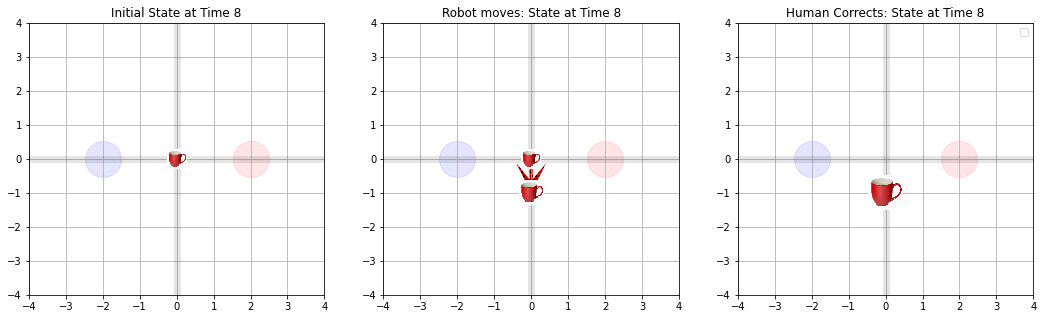

keytuple == (0,0)
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}
corrected_state_feat_wrt_candidate_phi [ 0.          2.23606798  2.23606798 -1.        ]
corrected_reward_wrt_candidate_wphi =  -8.94427190999916
subopt_reward_wrt_candidate_wphi =  -8.94427190999916
rew:  -8.94427190999916
upside down rew:  -13.085864563588952


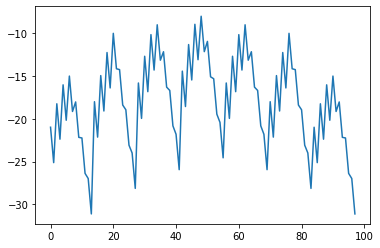

prob_data_given_w_phi 0.13638686320887244

keytuple == (0,4)
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}
corrected_state_feat_wrt_candidate_phi [ 0.          2.23606798  2.23606798 -1.        ]
corrected_reward_wrt_candidate_wphi =  -8.94427190999916
subopt_reward_wrt_candidate_wphi =  -8.94427190999916
rew:  -8.94427190999916
upside down rew:  -9.94427190999916


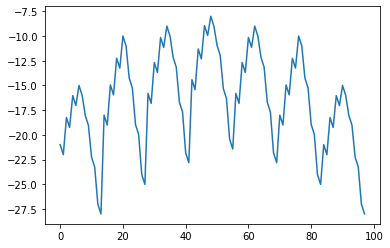

prob_data_given_w_phi 0.10129187620408374

keytuple == (4,0)
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 3.141592653589793}
corrected_state_feat_wrt_candidate_phi [ 0.          2.23606798  2.23606798 -1.        ]
corrected_reward_wrt_candidate_wphi =  -8.94427190999916
subopt_reward_wrt_candidate_wphi =  -8.94427190999916
rew:  -8.94427190999916
upside down rew:  -6.802679256409366


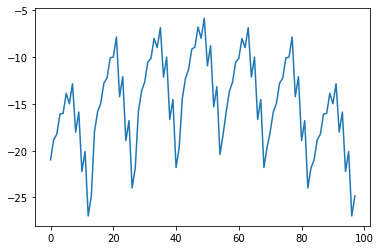

prob_data_given_w_phi 0.014564836792917894



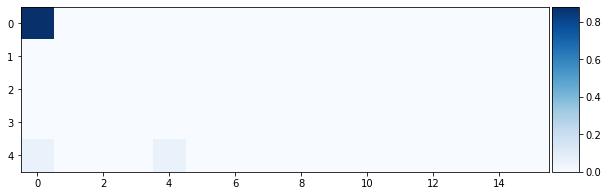

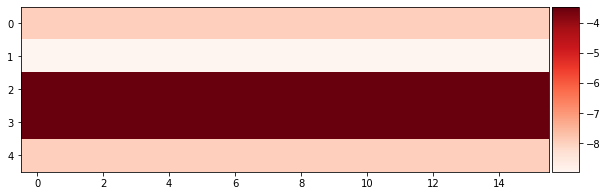

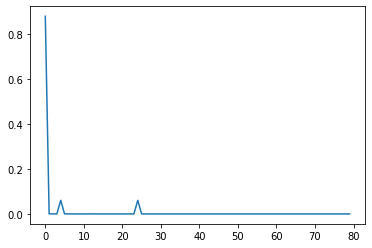

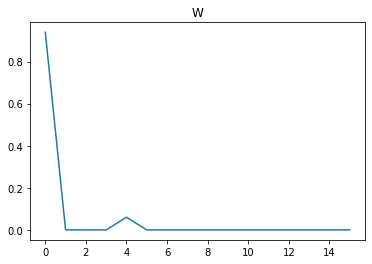

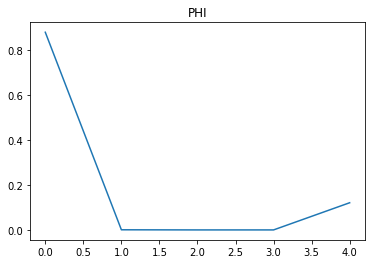

No handles with labels found to put in legend.


max_keytuple (0, 0)
map_robot_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}


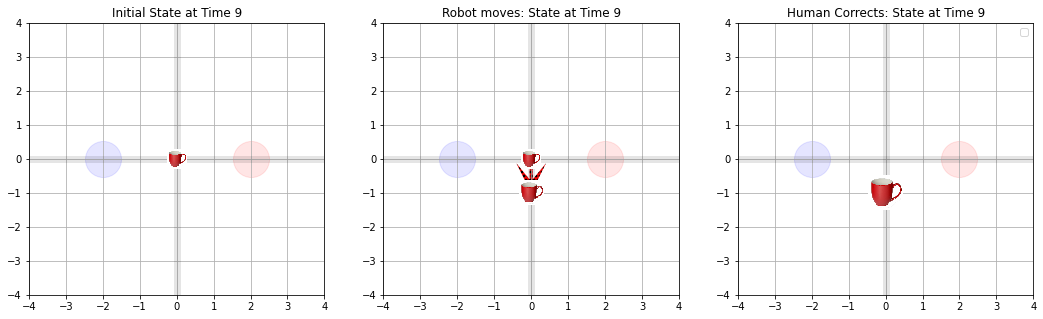

keytuple == (0,0)
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}
corrected_state_feat_wrt_candidate_phi [ 0.          2.23606798  2.23606798 -1.        ]
corrected_reward_wrt_candidate_wphi =  -8.94427190999916
subopt_reward_wrt_candidate_wphi =  -8.94427190999916
rew:  -8.94427190999916
upside down rew:  -13.085864563588952


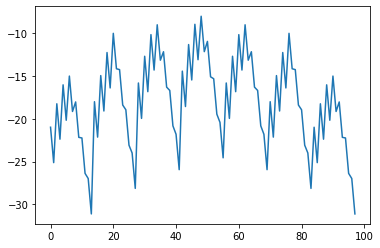

prob_data_given_w_phi 0.13638686320887244

keytuple == (0,4)
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}
corrected_state_feat_wrt_candidate_phi [ 0.          2.23606798  2.23606798 -1.        ]
corrected_reward_wrt_candidate_wphi =  -8.94427190999916
subopt_reward_wrt_candidate_wphi =  -8.94427190999916
rew:  -8.94427190999916
upside down rew:  -9.94427190999916


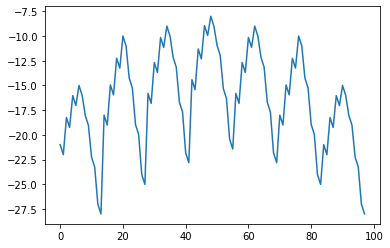

prob_data_given_w_phi 0.10129187620408374

keytuple == (4,0)
corrected_human_state {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 3.141592653589793}
corrected_state_feat_wrt_candidate_phi [ 0.          2.23606798  2.23606798 -1.        ]
corrected_reward_wrt_candidate_wphi =  -8.94427190999916
subopt_reward_wrt_candidate_wphi =  -8.94427190999916
rew:  -8.94427190999916
upside down rew:  -6.802679256409366


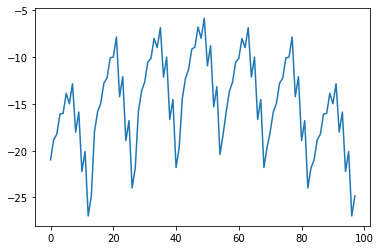

prob_data_given_w_phi 0.014564836792917894



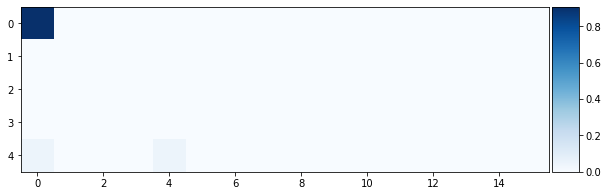

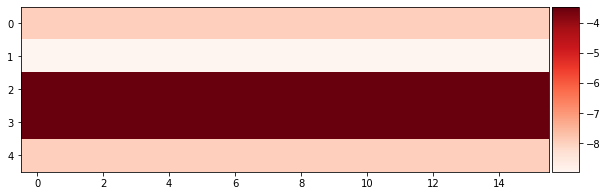

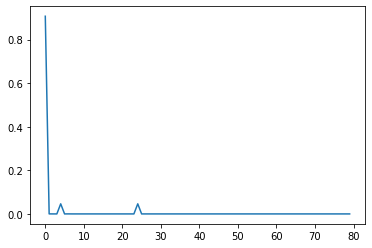

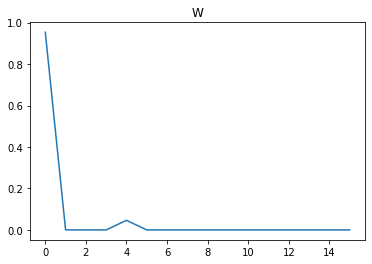

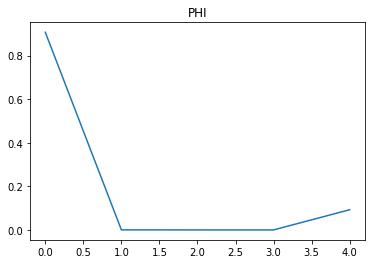

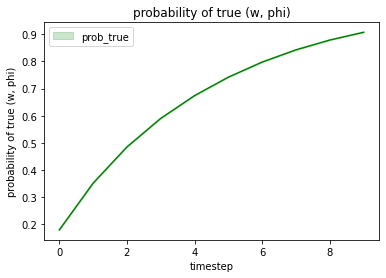

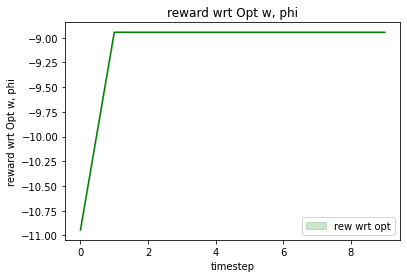

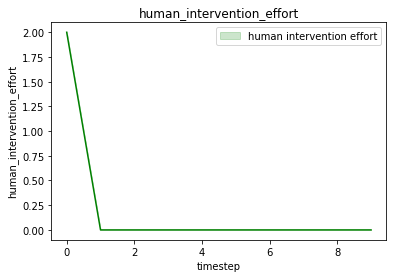

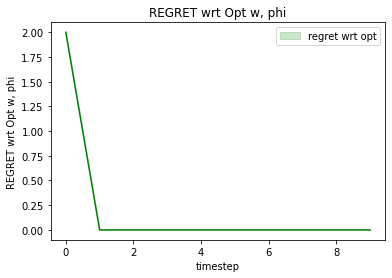

In [26]:
# true_reward_weights = [-1, -2, 2, -1]  # orientation, red prox, blue prox, pos y

# true_f_idx = [1, 1, 1, 1]
np.random.seed(0)
correct_keytuple = (0,0)

instances = 1
noise = 0.0

beta = 1
N_rounds_of_learning = 10
exp_data_prob_true = {t:[] for t in range(N_rounds_of_learning)}
exp_data_reward = {t:[] for t in range(N_rounds_of_learning)}
exp_data_human_intervention_effort = {t:[] for t in range(N_rounds_of_learning)}
exp_data_regret = {t:[] for t in range(N_rounds_of_learning)}
exp_data_eq_class = {}

for inst in range(instances):
    timestep = 0
    
    prob_of_true = []
    wf_tuple_to_beliefs = {}
    wf_tuple_to_rewards_wrt_max_prob_wf= {}
    for keytuple in wf_tup_to_hyp_idx_deets:
        wf_tuple_to_beliefs[keytuple] = 1/len(wf_tup_to_hyp_idx_deets)
        wf_tuple_to_rewards_wrt_max_prob_wf [keytuple] = 0
    
    true_phi = wf_tup_to_hyp_idx_deets[correct_keytuple]['f']
    true_w = wf_tup_to_hyp_idx_deets[correct_keytuple]['w']
    
    for timestep in range(N_rounds_of_learning):
#         if timestep == 1:
#             initial_state['orientation'] = -np.pi/2
#         if initial_state['orientation'] == 0:
#             initial_state['orientation'] = np.pi
#         else:
#             initial_state['orientation'] = 0
        # select hypothesis with max probability
        max_keytuple = None
        max_prob = -1000
        top_hypotheses = []
        for keyname in wf_tuple_to_beliefs:
            norm_prob = wf_tuple_to_beliefs[keyname]
            if norm_prob > max_prob:
                max_prob = norm_prob
                max_keytuple = keyname
                top_hypotheses = [keyname]
            elif norm_prob == max_prob:
                top_hypotheses.append(keyname)
        
        max_keytuple_idx = np.random.choice(range(len(top_hypotheses)))
        max_keytuple = top_hypotheses[max_keytuple_idx]
        if instances == 1:
            print("max_keytuple", max_keytuple)
        
#         break
#     break
        # Use random hypothesis
#         max_keytuple_idx = np.random.choice(range(len(wf_tuple_to_beliefs)))
#         wf_tuple_to_beliefs_keys = list(wf_tuple_to_beliefs.keys())
#         max_keytuple = wf_tuple_to_beliefs_keys[max_keytuple_idx]
        
        
        
#         print("max_keytuple", max_keytuple)
        

        # using max_keytuple, act on max_keytuple to get final state
        map_robot_state = wf_tup_to_hyp_idx_deets[max_keytuple]['final_state']
#         if map_robot_state['orientation'] == 0:
#                 map_robot_state['orientation'] = -np.pi/2
#         else:
#             map_robot_state['orientation'] = np.pi/2
        print("map_robot_state", map_robot_state)
        map_robot_state_feat_wrt_true_phi = featurize_state(map_robot_state, true_f_idx)

        # using correct keytuple, get corrected final state
        corrected_human_state = wf_tup_to_hyp_idx_deets[correct_keytuple]['final_state']
#         if corrected_human_state['orientation'] == 0:
#                 corrected_human_state['orientation'] = -np.pi/2
#         else:
#             corrected_human_state['orientation'] = np.pi/2
        print("corrected_human_state", corrected_human_state)
        corrected_human_state_feat_wrt_true_phi = featurize_state(corrected_human_state, true_f_idx)

        # PLOT CORRECTION ACTION
        if instances == 1:
            plot_correction(map_robot_state, corrected_human_state, initial_state, timestep)
        no_correction_made = False
#         print("map_robot_state", map_robot_state)
#         print("corrected_human_state", corrected_human_state)
        if map_robot_state == corrected_human_state:
#             print("NO CORRECTION MADE")
            no_correction_made = True
#         else:
#             print("CORRECTION MADE")


        # UPDATING WEIGHTS
        total = 0
        denom_for_likelihood = 0
        keytuple_to_likelihood = {}
        for keytuple in wf_tuple_to_beliefs:
            
            
            
            
            candidate_w = wf_tup_to_hyp_idx_deets[keytuple]['w']
            candidate_phi = wf_tup_to_hyp_idx_deets[keytuple]['f']
#             print("candidate_w", candidate_w)
#             print("candidate_phi", candidate_phi)

            # This candiate would place in which position
            hypothetical_human_state = wf_tup_to_hyp_idx_deets[keytuple]['final_state']
#             if hypothetical_human_state['orientation'] == 0:
#                 hypothetical_human_state['orientation'] = -np.pi/2
#             else:
#                 hypothetical_human_state['orientation'] = np.pi/2
                
            hypothetical_human_state_feat_wrt_cand_phi = featurize_state(hypothetical_human_state, candidate_phi)
            
            hypothetical_human_state_tup = state_to_tuple(hypothetical_human_state)
            
            if hypothetical_human_state_tup not in exp_data_eq_class:
                exp_data_eq_class[hypothetical_human_state_tup] = {t:0 for t in wf_tuple_to_beliefs}
            exp_data_eq_class[hypothetical_human_state_tup][keytuple] = 1
            
            map_robot_state_feat_wrt_candidate_phi = featurize_state(map_robot_state, candidate_phi)
            cost = abs(map_robot_state['grid'][RED_CUP][0] - initial_state['grid'][RED_CUP][0]) + \
                        abs(map_robot_state['grid'][RED_CUP][1] - initial_state['grid'][RED_CUP][1]) + \
                        (1 if map_robot_state['orientation'] !=initial_state['orientation'] else 0)
            subopt_reward_wrt_candidate_wphi = np.dot(map_robot_state_feat_wrt_candidate_phi, candidate_w)-cost

            corrected_state_feat_wrt_candidate_phi = featurize_state(corrected_human_state, candidate_phi)
            cost = abs(corrected_human_state['grid'][RED_CUP][0] - initial_state['grid'][RED_CUP][0]) + \
                        abs(corrected_human_state['grid'][RED_CUP][1] - initial_state['grid'][RED_CUP][1]) + \
                        (1 if corrected_human_state['orientation'] != initial_state['orientation'] else 0)
            corrected_reward_wrt_candidate_wphi = np.dot(corrected_state_feat_wrt_candidate_phi, candidate_w)-cost

            
            human_intervention_cost = abs(corrected_human_state['grid'][RED_CUP][0] - map_robot_state['grid'][RED_CUP][0]) + \
                        abs(corrected_human_state['grid'][RED_CUP][1] - map_robot_state['grid'][RED_CUP][1]) + \
                        (1 if corrected_human_state['orientation'] != map_robot_state['orientation'] else 0)
            
            optimal_cost = abs(corrected_human_state['grid'][RED_CUP][0] - initial_state['grid'][RED_CUP][0]) + \
                        abs(corrected_human_state['grid'][RED_CUP][1] - initial_state['grid'][RED_CUP][1]) + \
                        (1 if corrected_human_state['orientation'] != initial_state['orientation'] else 0)
            
            corrected_cost = optimal_cost + human_intervention_cost
            
            regret_current = (corrected_human_state_feat_wrt_true_phi - optimal_cost) - (corrected_human_state_feat_wrt_true_phi - corrected_cost) 
            
            
            diff = corrected_reward_wrt_candidate_wphi - subopt_reward_wrt_candidate_wphi
#             print("corrected_reward_wrt_candidate_wphi", corrected_reward_wrt_candidate_wphi)
#             print("subopt_reward_wrt_candidate_wphi", subopt_reward_wrt_candidate_wphi)
#             subopt_reward_wrt_candidate_wphi /= 100
#             corrected_reward_wrt_candidate_wphi /= 100
            rew_wrt_max_key = np.dot(featurize_state(map_robot_state, wf_tup_to_hyp_idx_deets[keytuple]['f']), 
                                     wf_tup_to_hyp_idx_deets[max_keytuple]['w'])
            wf_tuple_to_rewards_wrt_max_prob_wf[keytuple] = rew_wrt_max_key 
            
#             if diff == 0:
#                 prob_data_given_w_phi = 1
            
#             else:
#                 prob_data_given_w_phi = np.exp(beta*corrected_reward_wrt_candidate_wphi)/(np.exp(beta*corrected_reward_wrt_candidate_wphi)+np.exp(beta*subopt_reward_wrt_candidate_wphi))
            
            prob_data_given_w_phi_comparison = np.exp(beta*corrected_reward_wrt_candidate_wphi)/(np.exp(beta*corrected_reward_wrt_candidate_wphi)+np.exp(beta*subopt_reward_wrt_candidate_wphi))
            prob_data_given_w_phi = np.exp(beta*corrected_reward_wrt_candidate_wphi)
            denom_for_likelihood += prob_data_given_w_phi
            keytuple_to_likelihood[keytuple] = prob_data_given_w_phi
            
            denom_reward_over_actions = 0
            other_pos_to_rews = {}
            
            for cand_pos_x in range(-3,4):
#                 cost = 0
#                 cost = abs(cand_pos_x - initial_state['grid'][RED_CUP][0])
                for cand_pos_y in range(-3, 4):
                    
                    for orien in [0, np.pi]:
                        cost = abs(cand_pos_x - initial_state['grid'][RED_CUP][0]) + \
                        abs(cand_pos_y - initial_state['grid'][RED_CUP][1]) + \
                        (1 if orien != initial_state['orientation'] else 0)
                        cand_state = copy.deepcopy(initial_state)
                        cand_state['grid'][RED_CUP] = (cand_pos_x, cand_pos_y)   
                        cand_state['orientation'] = orien
                        cand_state_feat = featurize_state(cand_state, candidate_phi)
                        cand_rew = np.dot(cand_state_feat, candidate_w) - cost
                        cand_rew_exp = np.exp(beta*cand_rew)
                        denom_reward_over_actions += cand_rew_exp
                        other_pos_to_rews[(cand_pos_x, cand_pos_y, orien)] = cand_rew
            prob_data_given_w_phi /= denom_reward_over_actions
#             prob_data_given_w_phi *= prob_data_given_w_phi_comparison
#             prob_data_given_w_phi = prob_data_given_w_phi_comparison
            
#             if corrected_reward_wrt_candidate_wphi == subopt_reward_wrt_candidate_wphi:
#                 prob_data_given_w_phi = 1
#             else:
#                 prob_data_given_w_phi = 0.1
#             prob_data_given_w_phi = 1
            if keytuple == (0,0):
                print("keytuple == (0,0)")
                print("corrected_human_state", wf_tup_to_hyp_idx_deets[keytuple]['final_state'])
                print("corrected_state_feat_wrt_candidate_phi", corrected_state_feat_wrt_candidate_phi)
                print("corrected_reward_wrt_candidate_wphi = ", corrected_reward_wrt_candidate_wphi)
                print("subopt_reward_wrt_candidate_wphi = ", subopt_reward_wrt_candidate_wphi)
                print("rew: ", other_pos_to_rews[(map_robot_state['grid'][RED_CUP][0], 
                                                  map_robot_state['grid'][RED_CUP][1], 
                                                  0)])
                print("upside down rew: ", other_pos_to_rews[(map_robot_state['grid'][RED_CUP][0], 
                                                  map_robot_state['grid'][RED_CUP][1], 
                                                  np.pi)])
#                 print("other_pos_to_rews", other_pos_to_rews)
                plt.plot(range(len(other_pos_to_rews)), other_pos_to_rews.values())
                plt.show()
                print("prob_data_given_w_phi", prob_data_given_w_phi)
                print()
            if keytuple == (4,0):
                print("keytuple == (4,0)")
                print("corrected_human_state", wf_tup_to_hyp_idx_deets[keytuple]['final_state'])
                print("corrected_state_feat_wrt_candidate_phi", corrected_state_feat_wrt_candidate_phi)
                print("corrected_reward_wrt_candidate_wphi = ", corrected_reward_wrt_candidate_wphi)
                print("subopt_reward_wrt_candidate_wphi = ", subopt_reward_wrt_candidate_wphi)
#                 print("other_pos_to_rews", other_pos_to_rews)
                print("rew: ", other_pos_to_rews[(map_robot_state['grid'][RED_CUP][0], 
                                                  map_robot_state['grid'][RED_CUP][1], 
                                                 0)])
                print("upside down rew: ", other_pos_to_rews[(map_robot_state['grid'][RED_CUP][0], 
                                                  map_robot_state['grid'][RED_CUP][1], 
                                                  np.pi)])
                plt.plot(range(len(other_pos_to_rews)), other_pos_to_rews.values())
                plt.show()
        
                print("prob_data_given_w_phi", prob_data_given_w_phi)
                print()
            if keytuple == (0,4):
                print("keytuple == (0,4)")
                print("corrected_human_state", wf_tup_to_hyp_idx_deets[keytuple]['final_state'])
                print("corrected_state_feat_wrt_candidate_phi", corrected_state_feat_wrt_candidate_phi)
                print("corrected_reward_wrt_candidate_wphi = ", corrected_reward_wrt_candidate_wphi)
                print("subopt_reward_wrt_candidate_wphi = ", subopt_reward_wrt_candidate_wphi)
#                 print("other_pos_to_rews", other_pos_to_rews)
                print("rew: ", other_pos_to_rews[(map_robot_state['grid'][RED_CUP][0], 
                                                  map_robot_state['grid'][RED_CUP][1], 
                                                  0)])
                print("upside down rew: ", other_pos_to_rews[(map_robot_state['grid'][RED_CUP][0], 
                                                  map_robot_state['grid'][RED_CUP][1], 
                                                  np.pi)])
                plt.plot(range(len(other_pos_to_rews)), other_pos_to_rews.values())
                plt.show()
                print("prob_data_given_w_phi", prob_data_given_w_phi)
                print()

        
#             if no_correction_made:
#             init_robot_state_feat_wrt_candidate_phi = featurize_state(initial_state, candidate_phi)
#             subopt_reward_wrt_candidate_wphi = np.dot(init_robot_state_feat_wrt_candidate_phi, candidate_w)

#             corrected_state_feat_wrt_candidate_phi = featurize_state(corrected_human_state, candidate_phi)
#             corrected_reward_wrt_candidate_wphi = np.dot(corrected_state_feat_wrt_candidate_phi, candidate_w)
            
#             prob_data_given_w_phi *= np.exp(beta*corrected_reward_wrt_candidate_wphi)/(np.exp(beta*corrected_reward_wrt_candidate_wphi)+np.exp(beta*subopt_reward_wrt_candidate_wphi))
        
#         for keytuple in keytuple_to_likelihood:
#             prob_data_given_w_phi = keytuple_to_likelihood[keytuple]/denom_for_likelihood
        
        
#             print("prob_data_given_w_phi", prob_data_given_w_phi)
            new_prob = prob_data_given_w_phi * wf_tuple_to_beliefs[keytuple]
#             print("new_prob", new_prob)
#             print()
#             if no_correction_made:
#                 new_prob = wf_tuple_to_beliefs[keytuple]

            wf_tuple_to_beliefs[keytuple] = new_prob

            total += new_prob

        # NORMALIZE PROBS
        for keyname in wf_tuple_to_beliefs:
            norm_prob = wf_tuple_to_beliefs[keyname]/total
            wf_tuple_to_beliefs[keyname] = norm_prob

        # PLOT HEATMAP - TODO
        if instances ==1:
            plot_heatmap(wf_tuple_to_beliefs, perm_to_idx, w_to_idx)
            plot_rewardmap(wf_tuple_to_rewards_wrt_max_prob_wf, perm_to_idx, w_to_idx)

        # PLOT PROBABILITY OF TRUE
        prob_of_true_current = wf_tuple_to_beliefs[correct_keytuple]
        prob_of_true.append(prob_of_true_current)
        exp_data_prob_true[timestep].append(prob_of_true_current)
        exp_data_human_intervention_effort[timestep].append(human_intervention_cost)
        exp_data_regret[timestep].append(regret_current)
        
        # Get reward wrt to optimal w, phi
        map_robot_state_feat_wrt_candidate_phi = featurize_state(map_robot_state, candidate_phi)
        subopt_reward_wrt_candphi_truew = np.dot(map_robot_state_feat_wrt_candidate_phi, candidate_w)
        
        subopt_reward_wrt_truephi_truew = np.dot(featurize_state(map_robot_state, true_phi), true_w)
        
        cost = abs(corrected_human_state['grid'][RED_CUP][0] - initial_state['grid'][RED_CUP][0]) + \
                        abs(corrected_human_state['grid'][RED_CUP][1] - initial_state['grid'][RED_CUP][1]) + \
                        (1 if corrected_human_state['orientation'] != initial_state['orientation'] else 0)
        
        exp_data_reward[timestep].append(subopt_reward_wrt_truephi_truew - cost)
#         print("prob_of_true_current", prob_of_true_current)
        if instances == 1:
            plt.plot(range(len(wf_tuple_to_beliefs.keys())), wf_tuple_to_beliefs.values())
            plt.show()
            
            prob_w = {}
            prob_phi = {}
            for keytup in wf_tuple_to_beliefs:
                (w,f) = keytup
                if w not in prob_w:
                    prob_w[w] = 0
                if f not in prob_phi:
                    prob_phi[f] = 0
                prob_w[w] += wf_tuple_to_beliefs[keytup]
                prob_phi[f] += wf_tuple_to_beliefs[keytup]

            plt.plot(range(len(prob_w)), prob_w.values())
            plt.title("W")
            plt.show()

            plt.plot(range(len(prob_phi)), prob_phi.values())
            plt.title("PHI")
            plt.show()



#     plt.plot(range(len(wf_tuple_to_beliefs.keys())), wf_tuple_to_beliefs.values())
#     plt.show()
        
#     plt.plot(range(len(prob_of_true)), prob_of_true, c='r')
#     plt.show()

means = np.array([np.mean(exp_data_prob_true[i]) for i in range(len(exp_data_prob_true))])    
stds = np.array([np.std(exp_data_prob_true[i]) for i in range(len(exp_data_prob_true))])    
    
plt.plot(range(len(means)), means, c='g')
plt.fill_between(range(len(means)), means-stds, means+stds, alpha=0.2, color='g', label='prob_true')
    
plt.legend()
plt.title("probability of true (w, phi)")
plt.ylabel("probability of true (w, phi)")
plt.xlabel("timestep")
plt.show()
plt.close()


means = np.array([np.mean(exp_data_reward[i]) for i in range(len(exp_data_prob_true))])    
stds = np.array([np.std(exp_data_reward[i]) for i in range(len(exp_data_prob_true))])    
    
plt.plot(range(len(means)), means, c='g')
plt.fill_between(range(len(means)), means-stds, means+stds, alpha=0.2, color='g', label='rew wrt opt')
    
plt.legend()
plt.title("reward wrt Opt w, phi")
plt.ylabel("reward wrt Opt w, phi")
plt.xlabel("timestep")
plt.show()
plt.close()

means = np.array([np.mean(exp_data_human_intervention_effort[i]) for i in range(len(exp_data_prob_true))])    
stds = np.array([np.std(exp_data_human_intervention_effort[i]) for i in range(len(exp_data_prob_true))])    
    
plt.plot(range(len(means)), means, c='g')
plt.fill_between(range(len(means)), means-stds, means+stds, alpha=0.2, color='g', label='human intervention effort')
    
plt.legend()
plt.ylabel("human_intervention_effort")
plt.title("human_intervention_effort")
plt.xlabel("timestep")
plt.show()
plt.close()

means = np.array([np.mean(exp_data_regret[i]) for i in range(len(exp_data_prob_true))])    
stds = np.array([np.std(exp_data_regret[i]) for i in range(len(exp_data_prob_true))])    
    
plt.plot(range(len(means)), means, c='g')
plt.fill_between(range(len(means)), means-stds, means+stds, alpha=0.2, color='g', label='regret wrt opt')
    
plt.legend()
plt.ylabel("REGRET wrt Opt w, phi")
plt.title("REGRET wrt Opt w, phi")

plt.xlabel("timestep")
plt.show()
plt.close()



In [27]:
wf_tup_to_hyp_idx_deets[(1,0)]

{'index': 5,
 'prob': 0.0125,
 'f': [1, 1, 1, 1],
 'w': [-1, -2, -2, 1],
 'final_state_tuple': ((0, 1), 0),
 'final_state': {'grid': {(1, 1): (0, 1)}, 'exit': False, 'orientation': 0}}

In [28]:
wf_tup_to_hyp_idx_deets[(0,4)]

{'index': 4,
 'prob': 0.0125,
 'f': [0, 1, 1, 1],
 'w': [-1, -2, -2, -1],
 'final_state_tuple': ((0, -1), 0),
 'final_state': {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}}

In [29]:
wf_tup_to_hyp_idx_deets

{(0, 0): {'index': 0,
  'prob': 0.0125,
  'f': [1, 1, 1, 1],
  'w': [-1, -2, -2, -1],
  'final_state_tuple': ((0, -1), 0),
  'final_state': {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}},
 (0, 1): {'index': 1,
  'prob': 0.0125,
  'f': [1, 1, 1, 0],
  'w': [-1, -2, -2, -1],
  'final_state_tuple': ((0, 0), 0),
  'final_state': {'grid': {(1, 1): (0, 0)}, 'exit': False, 'orientation': 0}},
 (0, 2): {'index': 2,
  'prob': 0.0125,
  'f': [1, 1, 0, 1],
  'w': [-1, -2, -2, -1],
  'final_state_tuple': ((2, 0), 0),
  'final_state': {'grid': {(1, 1): (2, 0)}, 'exit': False, 'orientation': 0}},
 (0, 3): {'index': 3,
  'prob': 0.0125,
  'f': [1, 0, 1, 1],
  'w': [-1, -2, -2, -1],
  'final_state_tuple': ((-2, 0), 0),
  'final_state': {'grid': {(1, 1): (-2, 0)}, 'exit': False, 'orientation': 0}},
 (0, 4): {'index': 4,
  'prob': 0.0125,
  'f': [0, 1, 1, 1],
  'w': [-1, -2, -2, -1],
  'final_state_tuple': ((0, -1), 0),
  'final_state': {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientat

In [30]:
corrected_human_state = wf_tup_to_hyp_idx_deets[correct_keytuple]['final_state']
corrected_human_state

{'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}

In [31]:
keytuple = (0,0)
print("keytuple", keytuple)
candidate_w = wf_tup_to_hyp_idx_deets[keytuple]['w']
candidate_phi = wf_tup_to_hyp_idx_deets[keytuple]['f']

# for cand_pos_x in range(-3,4):
#     for cand_pos_y in range(-3, 4):

#         for orien in [-np.pi/2, np.pi/2]:
(cand_pos_x, cand_pos_y, orien) = (1,1, 0)
cost = abs(cand_pos_x - initial_state['grid'][RED_CUP][0]) + \
abs(cand_pos_y - initial_state['grid'][RED_CUP][1]) + \
(1 if orien == np.pi else 0)
cand_state = copy.deepcopy(initial_state)
cand_state['grid'][RED_CUP] = (cand_pos_x, cand_pos_y)   
cand_state['orientation'] = orien
cand_state_feat = featurize_state(cand_state, candidate_phi)
cand_rew = np.dot(cand_state_feat, candidate_w)
cand_rew_exp = np.power(1.1, beta*cand_rew)
denom_reward_over_actions += cand_rew_exp
other_pos_to_rews[(cand_pos_x, cand_pos_y, orien)] = cand_rew

print("candidate_w, candidate_phi", (candidate_w, candidate_phi))
print("cand_state_feat", cand_state_feat)
print("cand_rew", cand_rew)
print("cand_rew_exp", cand_rew_exp)
print("cost", cost)


keytuple (0, 0)
candidate_w, candidate_phi ([-1, -2, -2, -1], [1, 1, 1, 1])
cand_state_feat [0.         1.41421356 3.16227766 1.        ]
cand_rew -10.15298244508295
cand_rew_exp 0.3799625505163325
cost 2


In [32]:
keytuple = (1,0)
print("keytuple", keytuple)
candidate_w = wf_tup_to_hyp_idx_deets[keytuple]['w']
candidate_phi = wf_tup_to_hyp_idx_deets[keytuple]['f']

# for cand_pos_x in range(-3,4):
#     for cand_pos_y in range(-3, 4):

#         for orien in [-np.pi/2, np.pi/2]:
(cand_pos_x, cand_pos_y, orien) = (1,1, 0)
cost = abs(cand_pos_x - initial_state['grid'][RED_CUP][0]) + \
abs(cand_pos_y - initial_state['grid'][RED_CUP][1]) + \
(1 if orien == np.pi else 0)
cand_state = copy.deepcopy(initial_state)
cand_state['grid'][RED_CUP] = (cand_pos_x, cand_pos_y)   
cand_state['orientation'] = orien
cand_state_feat = featurize_state(cand_state, candidate_phi)
cand_rew = np.dot(cand_state_feat, candidate_w) 
cand_rew_exp = np.power(1.1, beta*cand_rew)
denom_reward_over_actions += cand_rew_exp
other_pos_to_rews[(cand_pos_x, cand_pos_y, orien)] = cand_rew
            
    
print("candidate_w, candidate_phi", (candidate_w, candidate_phi))
print("cand_state_feat", cand_state_feat)
print("cand_rew", cand_rew)
print("cand_rew_exp", cand_rew_exp)
print("cost", cost)


keytuple (1, 0)
candidate_w, candidate_phi ([-1, -2, -2, 1], [1, 1, 1, 1])
cand_state_feat [0.         1.41421356 3.16227766 1.        ]
cand_rew -8.15298244508295
cand_rew_exp 0.4597546861247624
cost 2


In [33]:
keytuple = (0,0)
print("keytuple", keytuple)
candidate_w = wf_tup_to_hyp_idx_deets[keytuple]['w']
candidate_phi = wf_tup_to_hyp_idx_deets[keytuple]['f']

# for cand_pos_x in range(-3,4):
#     for cand_pos_y in range(-3, 4):

#         for orien in [-np.pi/2, np.pi/2]:
(cand_pos_x, cand_pos_y, orien) = (1,1, 0)
cost = abs(cand_pos_x - initial_state['grid'][RED_CUP][0]) + \
abs(cand_pos_y - initial_state['grid'][RED_CUP][1]) + \
(1 if orien == np.pi else 0)
cand_state = copy.deepcopy(initial_state)
cand_state['grid'][RED_CUP] = (cand_pos_x, cand_pos_y)   
cand_state['orientation'] = orien
cand_state_feat = featurize_state(cand_state, candidate_phi)
cand_rew = np.dot(cand_state_feat, candidate_w) - cost
cand_rew_exp = np.power(1.1, beta*cand_rew)
denom_reward_over_actions += cand_rew_exp
other_pos_to_rews[(cand_pos_x, cand_pos_y, orien)] = cand_rew
            
# # prob_data_given_w_phi /= denom_reward_over_actions
# it_reward =cand_rew
# print("candidate_w, candidate_phi", (candidate_w, candidate_phi))
# print("cand_state_feat", cand_state_feat)
# print("cand_rew", cand_rew)
# print("cand_rew_exp", cand_rew_exp)
# print("cost", cost)

# max_reward = -100
# max_reward_exp = 0
# max_pos = None
# denom_reward_over_actions = 0
# for cand_pos_x in range(-3,4):
#     for cand_pos_y in range(-3, 4):

#         for orien in [-np.pi/2, np.pi/2]:
#             # (cand_pos_x, cand_pos_y, orien) = (0, -1, -np.pi/2)
#             cost = abs(cand_pos_x - initial_state['grid'][RED_CUP][0]) + \
#             abs(cand_pos_y - initial_state['grid'][RED_CUP][1]) + \
#             (1 if orien == -np.pi/2 else 0)
#             cand_state = copy.deepcopy(initial_state)
#             cand_state['grid'][RED_CUP] = (cand_pos_x, cand_pos_y)   
#             cand_state['orientation'] = orien
#             cand_state_feat = featurize_state(cand_state, candidate_phi)
#             cand_rew = np.dot(cand_state_feat, candidate_w) - cost
#             cand_rew_exp = np.power(1.1, beta*cand_rew)
#             denom_reward_over_actions += cand_rew_exp
#             other_pos_to_rews[(cand_pos_x, cand_pos_y, orien)] = cand_rew
#             if (cand_pos_x, cand_pos_y, orien) == (0, -1, -np.pi/2):
#                 print("cand_rew for max", cand_rew)
#             if cand_rew > max_reward:
#                 max_reward = cand_rew
#                 max_reward_exp = cand_rew_exp
#                 max_pos = cand_pos_x, cand_pos_y, orien
            
# print("denom_reward_over_actions", denom_reward_over_actions)
# print("prop = ", cand_rew_exp/denom_reward_over_actions)
# print("max_reward", max_reward)
# print("max_reward_exp", max_reward_exp)
# print("max_pos", max_pos)

# print()
# print("diff = ", max_reward - it_reward)



keytuple (0, 0)


In [34]:
keytuple = (5,2)
print("keytuple", keytuple)
candidate_w = wf_tup_to_hyp_idx_deets[keytuple]['w']
candidate_phi = wf_tup_to_hyp_idx_deets[keytuple]['f']

# for cand_pos_x in range(-3,4):
#     for cand_pos_y in range(-3, 4):

#         for orien in [-np.pi/2, np.pi/2]:
(cand_pos_x, cand_pos_y, orien) = (1,1, 0)
cost = abs(cand_pos_x - initial_state['grid'][RED_CUP][0]) + \
abs(cand_pos_y - initial_state['grid'][RED_CUP][1]) + \
(1 if orien == np.pi/2 else 0)
cand_state = copy.deepcopy(initial_state)
cand_state['grid'][RED_CUP] = (cand_pos_x, cand_pos_y)   
cand_state['orientation'] = orien
cand_state_feat = featurize_state(cand_state, candidate_phi)
cand_rew = np.dot(cand_state_feat, candidate_w) - cost
cand_rew_exp = np.power(1.1, beta*cand_rew)
denom_reward_over_actions += cand_rew_exp
other_pos_to_rews[(cand_pos_x, cand_pos_y, orien)] = cand_rew
            
# prob_data_given_w_phi /= denom_reward_over_actions

print("candidate_w, candidate_phi", (candidate_w, candidate_phi))
print("cand_state_feat", cand_state_feat)
print("cand_rew_exp", cand_rew_exp)
print("cost", cost)

max_reward = 0
denom_reward_over_actions = 0
for cand_pos_x in range(-3,4):
    for cand_pos_y in range(-3, 4):

        for orien in [-np.pi/2, np.pi/2]:
            # (cand_pos_x, cand_pos_y, orien) = (0, -1, -np.pi/2)
            cost = abs(cand_pos_x - initial_state['grid'][RED_CUP][0]) + \
            abs(cand_pos_y - initial_state['grid'][RED_CUP][1]) + \
            (1 if orien == np.pi/2 else 0)
            cand_state = copy.deepcopy(initial_state)
            cand_state['grid'][RED_CUP] = (cand_pos_x, cand_pos_y)   
            cand_state['orientation'] = orien
            cand_state_feat = featurize_state(cand_state, candidate_phi)
            cand_rew = np.dot(cand_state_feat, candidate_w) - cost
            cand_rew_exp = np.power(1.1, beta*cand_rew)
            denom_reward_over_actions += cand_rew_exp
            other_pos_to_rews[(cand_pos_x, cand_pos_y, orien)] = cand_rew
            if cand_rew_exp > max_reward:
                max_reward = cand_rew_exp
            
print("denom_reward_over_actions", denom_reward_over_actions)
print("prop = ", cand_rew_exp/denom_reward_over_actions)
print("max_reward", max_reward)

keytuple (5, 2)
candidate_w, candidate_phi ([-1, -2, 2, 1], [1, 1, 0, 1])
cand_state_feat [0.         1.41421356 0.         1.        ]
cand_rew_exp 0.6942743513623858
cost 2
denom_reward_over_actions 40.771193952789034
prop =  0.007893434777734838
max_reward 0.959917938151792


In [35]:
keytuple = (4,0)
print("keytuple", keytuple)
candidate_w = wf_tup_to_hyp_idx_deets[keytuple]['w']
candidate_phi = wf_tup_to_hyp_idx_deets[keytuple]['f']

# for cand_pos_x in range(-3,4):
#     for cand_pos_y in range(-3, 4):

#         for orien in [-np.pi/2, np.pi/2]:
(cand_pos_x, cand_pos_y, orien) = (0, -1, -np.pi/2)
cost = abs(cand_pos_x - initial_state['grid'][RED_CUP][0]) + \
abs(cand_pos_y - initial_state['grid'][RED_CUP][1]) + \
(1 if orien == np.pi/2 else 0)
cand_state = copy.deepcopy(initial_state)
cand_state['grid'][RED_CUP] = (cand_pos_x, cand_pos_y)   
cand_state['orientation'] = orien
cand_state_feat = featurize_state(cand_state, candidate_phi)
cand_rew = np.dot(cand_state_feat, candidate_w) - cost
cand_rew_exp = np.power(1.1, beta*cand_rew)
denom_reward_over_actions += cand_rew_exp
other_pos_to_rews[(cand_pos_x, cand_pos_y, orien)] = cand_rew
            
# prob_data_given_w_phi /= denom_reward_over_actions

print("candidate_w, candidate_phi", (candidate_w, candidate_phi))
print("cand_state_feat", cand_state_feat)
print("cand_rew_exp", cand_rew_exp)
print("cost", cost)

max_reward = 0
denom_reward_over_actions = 0
for cand_pos_x in range(-3,4):
    for cand_pos_y in range(-3, 4):

        for orien in [-np.pi/2, np.pi/2]:
            # (cand_pos_x, cand_pos_y, orien) = (0, -1, -np.pi/2)
            cost = abs(cand_pos_x - initial_state['grid'][RED_CUP][0]) + \
            abs(cand_pos_y - initial_state['grid'][RED_CUP][1]) + \
            (1 if orien == np.pi/2 else 0)
            cand_state = copy.deepcopy(initial_state)
            cand_state['grid'][RED_CUP] = (cand_pos_x, cand_pos_y)   
            cand_state['orientation'] = orien
            cand_state_feat = featurize_state(cand_state, candidate_phi)
            cand_rew = np.dot(cand_state_feat, candidate_w) - cost
            cand_rew_exp = np.power(1.1, beta*cand_rew)
            denom_reward_over_actions += cand_rew_exp
            other_pos_to_rews[(cand_pos_x, cand_pos_y, orien)] = cand_rew
            if cand_rew_exp > max_reward:
                max_reward = cand_rew_exp
            
print("denom_reward_over_actions", denom_reward_over_actions)
print("prop = ", cand_rew_exp/denom_reward_over_actions)
print("max_reward", max_reward)

keytuple (4, 0)
candidate_w, candidate_phi ([1, -2, -2, -1], [1, 1, 1, 1])
cand_state_feat [-1.57079633  2.23606798  2.23606798 -1.        ]
cand_rew_exp 0.3670735492598982
cost 1
denom_reward_over_actions 22.45703030627267
prop =  0.0035911410396460464
max_reward 0.4925896827978733


In [36]:
candidate_w, candidate_phi

([1, -2, -2, -1], [1, 1, 1, 1])

In [37]:
candidate_w, candidate_phi

([1, -2, -2, -1], [1, 1, 1, 1])

In [38]:
cand_state_feat

array([1.57079633, 3.16227766, 5.83095189, 3.        ])

In [39]:
cand_rew

-26.415662783232463

In [40]:
keytuple = (0,0)
candidate_w = wf_tup_to_hyp_idx_deets[keytuple]['w']
candidate_phi = wf_tup_to_hyp_idx_deets[keytuple]['f']

denom_reward_over_actions = 0
grid = {}

for cand_pos_x in range(-3,4):
    for cand_pos_y in range(-3, 4):
        cand_state = copy.deepcopy(initial_state)
        cand_state['grid'][RED_CUP] = (cand_pos_x, cand_pos_y)            
        cand_state_feat = featurize_state(cand_state, candidate_phi)
        cand_rew = np.dot(cand_state_feat, candidate_w)
        grid[(cand_pos_x, cand_pos_y)] =cand_rew

In [41]:
keytuple

(0, 0)

In [42]:
max(grid, key=grid.get)

(0, -1)

In [43]:
wf_tuple_to_beliefs[(0,0)]

0.9071053634962238

In [44]:
wf_tuple_to_beliefs[(4,0)]

1.7498005511851281e-10

state (0, -1)


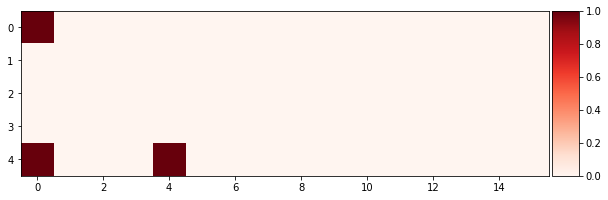

state (0, 0)


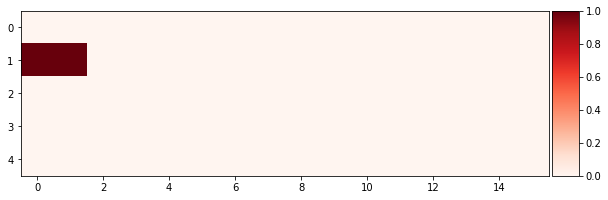

state (2, 0)


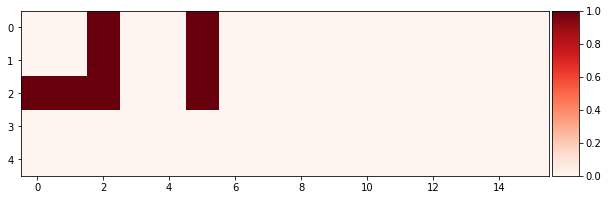

state (-2, 0)


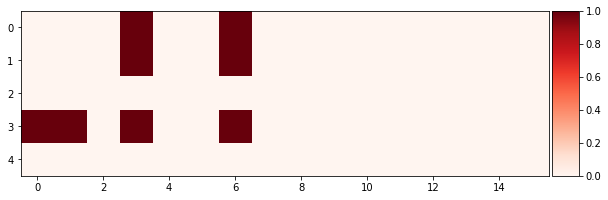

state (0, 1)


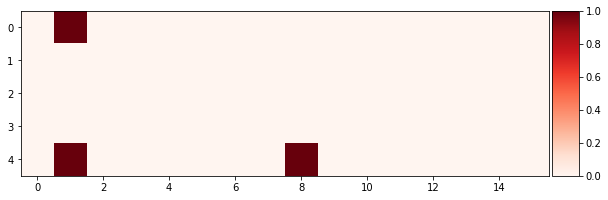

state (3, -3)


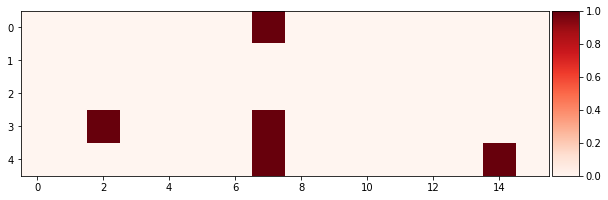

state (3, -1)


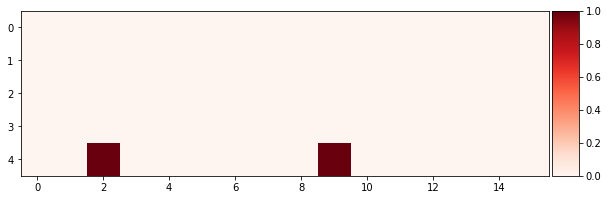

state (-3, -3)


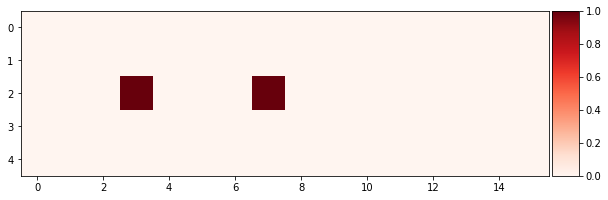

state (-3, -1)


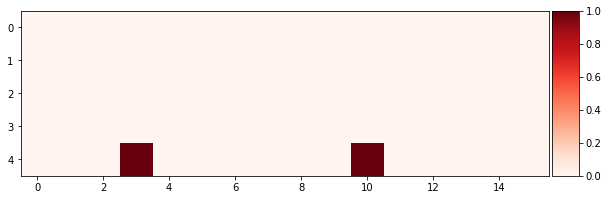

state (0, -1)


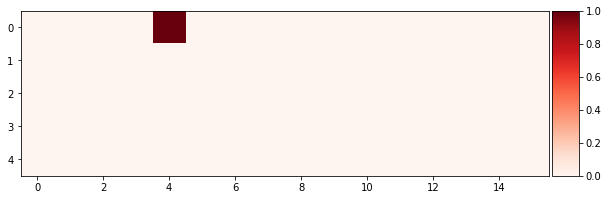

state (0, 0)


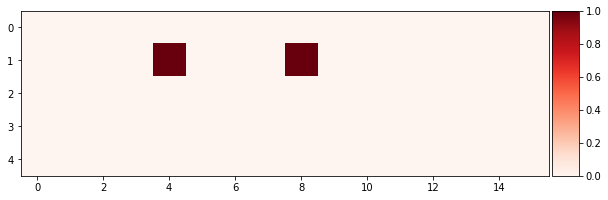

state (2, 0)


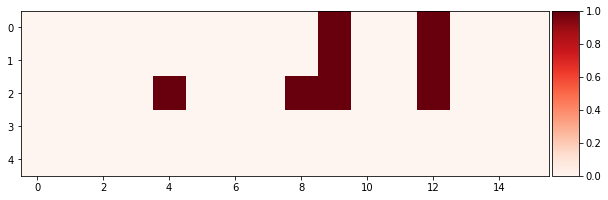

state (-2, 0)


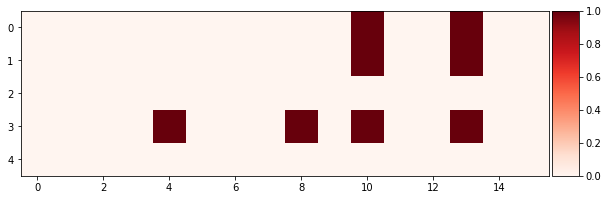

state (3, 3)


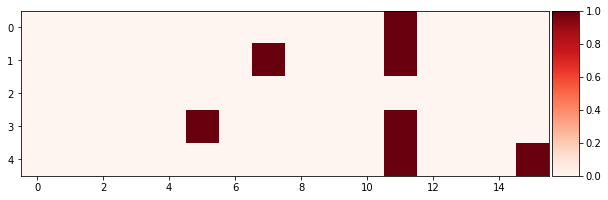

state (3, 1)


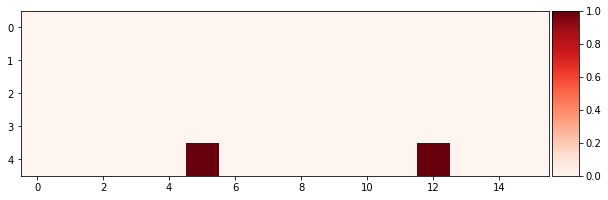

state (-3, 3)


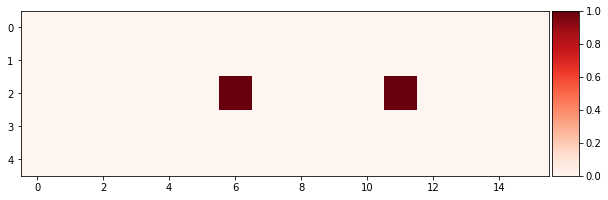

state (-3, 1)


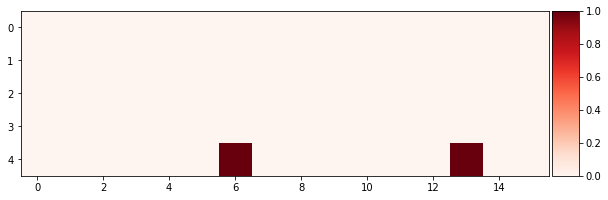

state (0, 1)


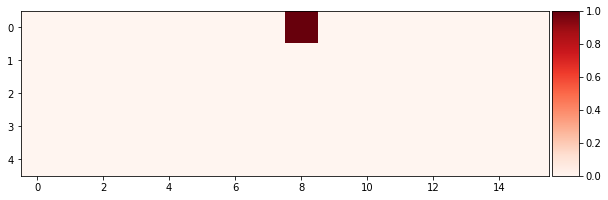

state (3, -3)


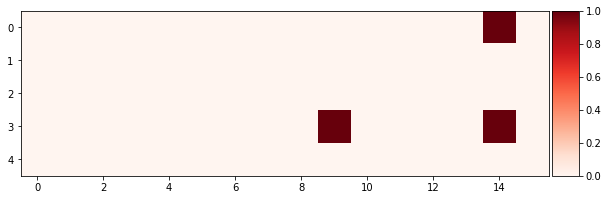

state (-3, -3)


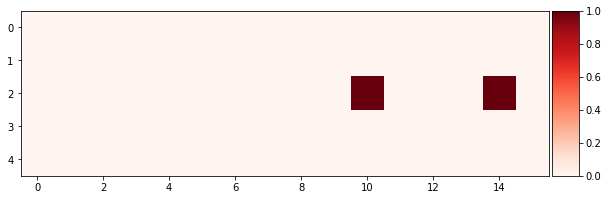

state (3, 3)


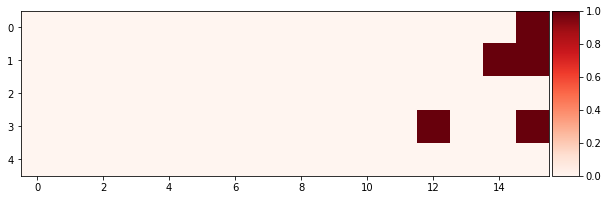

state (-3, 3)


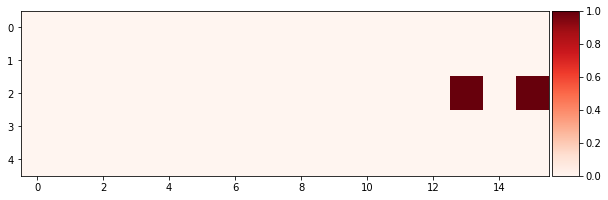

In [45]:
for hypothetical_human_state_tup in exp_data_eq_class:
    grid = exp_data_eq_class[hypothetical_human_state_tup]
    state = tuple_to_state(hypothetical_human_state_tup)
    print("state", state['grid'][RED_CUP])
    plot_rewardmap(grid, perm_to_idx, w_to_idx)


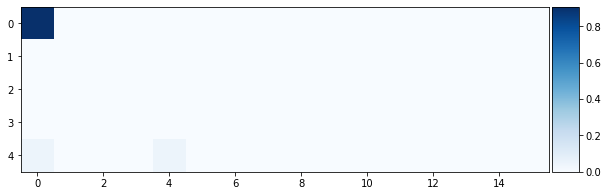

In [46]:
plot_heatmap(wf_tuple_to_beliefs, perm_to_idx, w_to_idx)

In [47]:
tup = tuple([0,0])
print(tup)
print(wf_tup_to_hyp_idx_deets[tup])
print(wf_tuple_to_beliefs[tup])
print()

tup = tuple([2,0])
print(tup)
print(wf_tup_to_hyp_idx_deets[tup])
print(wf_tuple_to_beliefs[tup])
print()


tup = tuple([0,2])
print(tup)
print(wf_tup_to_hyp_idx_deets[tup])
print(wf_tuple_to_beliefs[tup])
print()


tup = tuple([2,2])
print(tup)
print(wf_tup_to_hyp_idx_deets[tup])
print(wf_tuple_to_beliefs[tup])
print()

tup = tuple([0,4])
print(tup)
print(wf_tup_to_hyp_idx_deets[tup])
print(wf_tuple_to_beliefs[tup])
print()


tup = tuple([2,4])
print(tup)
print(wf_tup_to_hyp_idx_deets[tup])
print(wf_tuple_to_beliefs[tup])
print()


(0, 0)
{'index': 0, 'prob': 0.0125, 'f': [1, 1, 1, 1], 'w': [-1, -2, -2, -1], 'final_state_tuple': ((0, -1), 0), 'final_state': {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}}
0.9071053634962238

(2, 0)
{'index': 10, 'prob': 0.0125, 'f': [1, 1, 1, 1], 'w': [-1, -2, 2, -1], 'final_state_tuple': ((2, 0), 0), 'final_state': {'grid': {(1, 1): (2, 0)}, 'exit': False, 'orientation': 0}}
2.1720858574952834e-21

(0, 2)
{'index': 2, 'prob': 0.0125, 'f': [1, 1, 0, 1], 'w': [-1, -2, -2, -1], 'final_state_tuple': ((2, 0), 0), 'final_state': {'grid': {(1, 1): (2, 0)}, 'exit': False, 'orientation': 0}}
3.4871022877409387e-06

(2, 2)
{'index': 12, 'prob': 0.0125, 'f': [1, 1, 0, 1], 'w': [-1, -2, 2, -1], 'final_state_tuple': ((2, 0), 0), 'final_state': {'grid': {(1, 1): (2, 0)}, 'exit': False, 'orientation': 0}}
3.4871022877409387e-06

(0, 4)
{'index': 4, 'prob': 0.0125, 'f': [0, 1, 1, 1], 'w': [-1, -2, -2, -1], 'final_state_tuple': ((0, -1), 0), 'final_state': {'grid': {(1, 1): (0, -1)}

In [48]:
max_keytuple_idx = np.random.choice(range(len(wf_tuple_to_beliefs)))
wf_tuple_to_beliefs_keys = list(wf_tuple_to_beliefs.keys())
max_keytuple = wf_tuple_to_beliefs_keys[max_keytuple_idx]

In [49]:
max_keytuple

(9, 2)

In [50]:
max_keytuple

(9, 2)

In [51]:
print([4,0])
print(wf_tup_to_hyp_idx_deets[(4,0)])
print(wf_tuple_to_beliefs[(4,0)])
print()


print([0,0])
print(wf_tup_to_hyp_idx_deets[(0,0)])
print(wf_tuple_to_beliefs[(0,0)])
print()


print([0,4])
print(wf_tup_to_hyp_idx_deets[(0,4)])
print(wf_tuple_to_beliefs[(0,4)])
print()


print([4,4])
print(wf_tup_to_hyp_idx_deets[(4,4)])
print(wf_tuple_to_beliefs[(4,4)])
print()


[4, 0]
{'index': 20, 'prob': 0.0125, 'f': [1, 1, 1, 1], 'w': [1, -2, -2, -1], 'final_state_tuple': ((0, -1), 3.141592653589793), 'final_state': {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 3.141592653589793}}
1.7498005511851281e-10

[0, 0]
{'index': 0, 'prob': 0.0125, 'f': [1, 1, 1, 1], 'w': [-1, -2, -2, -1], 'final_state_tuple': ((0, -1), 0), 'final_state': {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}}
0.9071053634962238

[0, 4]
{'index': 4, 'prob': 0.0125, 'f': [0, 1, 1, 1], 'w': [-1, -2, -2, -1], 'final_state_tuple': ((0, -1), 0), 'final_state': {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}}
0.046310394389156094

[4, 4]
{'index': 24, 'prob': 0.0125, 'f': [0, 1, 1, 1], 'w': [1, -2, -2, -1], 'final_state_tuple': ((0, -1), 0), 'final_state': {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}}
0.046310394389156094



In [52]:
wf_tup_to_hyp_idx_deets[(0,0)]

{'index': 0,
 'prob': 0.0125,
 'f': [1, 1, 1, 1],
 'w': [-1, -2, -2, -1],
 'final_state_tuple': ((0, -1), 0),
 'final_state': {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}}

In [53]:
wf_tup_to_hyp_idx_deets[(0,4)]

{'index': 4,
 'prob': 0.0125,
 'f': [0, 1, 1, 1],
 'w': [-1, -2, -2, -1],
 'final_state_tuple': ((0, -1), 0),
 'final_state': {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}}

In [54]:
wf_tup_to_hyp_idx_deets[(4,4)]

{'index': 24,
 'prob': 0.0125,
 'f': [0, 1, 1, 1],
 'w': [1, -2, -2, -1],
 'final_state_tuple': ((0, -1), 0),
 'final_state': {'grid': {(1, 1): (0, -1)}, 'exit': False, 'orientation': 0}}

In [55]:
max(list(wf_tuple_to_beliefs.values()))

0.9071053634962238

In [56]:
wf_tuple_to_beliefs[(max_keytuple)]

6.726598420287562e-16

In [57]:
max_keytuple

(9, 2)

In [58]:
wf_tuple_to_beliefs[(0,0)]

0.9071053634962238